<a href="https://colab.research.google.com/github/Sam-ai904/Huatai-Model/blob/main/%E9%81%97%E4%BC%A0%E8%A7%84%E5%88%92%2B%E5%9B%A0%E5%AD%90%E5%90%88%E6%88%90%2B%E5%9B%9E%E6%B5%8B%EF%BC%88%E7%A0%94%E6%8A%A5%E7%89%88%2B%E9%AB%98%E6%80%A7%E8%83%BD%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install tushare bottleneck
import tushare as ts
import pandas as pd
import numpy as np
import random
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
import bottleneck as bn
# 安装支持中文的字体
#!apt-get install -y fonts-noto-cjk
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 刷新字体缓存
# fm.fontManager.ttflist.extend(
#     fm.createFontList('/usr/share/fonts/truetype/noto/NotoSansCJK*.ttc')
# )

# 设置 matplotlib 使用 Noto Sans CJK SC 字体
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK SC']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

from google.colab import drive
import json
import os

In [2]:
# 设置Tushare API Token并初始化
ts.set_token('2876ea85cb005fb5fa17c809a98174f2d5aae8b1f830110a5ead6211')
pro = ts.pro_api()


In [3]:
# 获取沪深300成分股前50
def get_shangzheng_top100(start_date , end_date):
    try:
        df = pro.index_weight(index_code='000001.SH', start_date= start_date, end_date= end_date)
        if df.empty:
            raise ValueError("未获取到上证指数成分股数据")

        df = df.sort_values('weight', ascending=False)
        stock_list = df['con_code'].unique()[:100].tolist()
        print(f"成功获取上证指数前100只股票: {stock_list[:6]}...（共 {len(stock_list)} 只）")
        return stock_list

    except Exception as e:
        print(f"获取上证指数成分股失败: {e}")
        return []

# 获取股票日频数据
def get_data(start_date, end_date, stock_list):
    df_list = []
    for stock in stock_list:
        try:
            temp_df = pro.daily(
                ts_code=stock,
                start_date=start_date,
                end_date=end_date,
                fields='ts_code,trade_date,open,close,high,low,vol,pct_chg'
            )
            if not temp_df.empty:
                # print(f"股票 {stock} 在 {start_date} 至 {end_date} 获取到 {len(temp_df)} 条数据")
                df_list.append(temp_df)
            else:
                print(f"股票 {stock} 在 {start_date} 至 {end_date} 无数据")
        except Exception as e:
            print(f"获取股票 {stock} 数据失败: {e}")

    if not df_list:
        print(f"时间范围 {start_date} 至 {end_date} 无任何股票数据")
        return pd.DataFrame()

    try:
        df = pd.concat(df_list)
        df.rename(columns={'vol': 'volume', 'pct_chg': 'return'}, inplace=True)
        df['return'] = df['return'] / 100
        df['trade_date'] = pd.to_datetime(df['trade_date'])

        # 检查并移除重复的 trade_date 和 ts_code 组合
        duplicates = df.duplicated(subset=['trade_date', 'ts_code'], keep=False)
        if duplicates.any():
            print(f"警告: 发现重复数据，共 {duplicates.sum()} 条，自动保留最后一条")
            df = df.drop_duplicates(subset=['trade_date', 'ts_code'], keep='last')

        # 重塑数据
        df_pivot = df.pivot(index='trade_date', columns='ts_code')

        # 检查收益率数据
        if 'return' in df_pivot:
            return_stats = df_pivot['return'].describe()
            print(f"收益率统计: {return_stats}")
            # 过滤收益率全为 NaN 或常数的股票
            valid_stocks = return_stats.loc['std'] > 0
            valid_stocks = valid_stocks[valid_stocks].index.tolist()
            if not valid_stocks:
                print("所有股票的收益率均为常数或 NaN，无法继续")
                return pd.DataFrame()
            df_pivot = df_pivot.loc[:, df_pivot.columns.get_level_values(1).isin(valid_stocks)]

        return df_pivot

    except Exception as e:
        print(f"数据合并失败: {e}")
        return pd.DataFrame()

In [4]:
# 中位数去极值函数
def winsorize_median(factor, n_mad=5):
    factor = factor.copy()
    # 计算中位数
    median = np.nanmedian(factor)
    # 计算中位数绝对偏差 (MAD)
    mad = np.nanmedian(np.abs(factor - median))
    # 设定上下限
    upper = median + n_mad * mad
    lower = median - n_mad * mad
    # 截断极值
    factor = np.clip(factor, lower, upper)
    return factor

In [5]:
# 标准化函数
def standardize(factor):
    factor = factor.copy()
    mean = np.nanmean(factor)
    std = np.nanstd(factor)
    return (factor - mean) / (std + 1e-10)  # 避免除以零

In [6]:
# 计算所有因子的值
def calculate_all_factors(data, factor_expressions, target_shape):
    factors = []
    # 使用 target 的展平长度来确定样本数
    expected_length = target_shape[0]
    for expr in factor_expressions:
        try:
            # 计算因子值
            factor_values = eval(expr, {'np': np, 'bn': bn}, {'data': data})
            # 展平为1维数组
            if isinstance(factor_values, pd.DataFrame):
                factor_values_flat = factor_values.values.flatten()
            else:
                factor_values_flat = factor_values.flatten()

            # 确保因子值长度与 target 对齐
            if len(factor_values_flat) != expected_length:
                print(f"因子 {expr} 的展平长度 {len(factor_values_flat)} 与目标长度 {expected_length} 不一致，调整中...")
                # 截断或填充因子值
                if len(factor_values_flat) > expected_length:
                    factor_values_flat = factor_values_flat[:expected_length]
                else:
                    # 填充 NaN 至目标长度
                    factor_values_flat = np.pad(factor_values_flat, (0, expected_length - len(factor_values_flat)),
                                               mode='constant', constant_values=np.nan)

            # 去极值和标准化
            factor_values_flat = standardize(winsorize_median(factor_values_flat))
            factors.append(factor_values_flat)

        except Exception as e:
            print(f"计算因子 {expr} 失败: {e}")
            factors.append(np.full(expected_length, np.nan))

    # 转换为 (样本数, 因子数) 的矩阵
    factors = np.array(factors).T
    return factors

In [7]:
# 使用随机森林进行因子合成
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 使用随机森林进行因子合成
def synthesize_with_random_forest(factors, target, test_size=0.2, random_state=42):
    # 确保 factors 和 target 的样本数一致
    if factors.shape[0] != len(target):
        raise ValueError(f"factors 形状 {factors.shape[0]} 与 target 长度 {len(target)} 不一致")

    # 确保没有 NaN 值
    valid_mask = ~np.any(np.isnan(factors), axis=1) & ~np.isnan(target)
    factors_clean = factors[valid_mask]
    target_clean = target[valid_mask]

    if len(factors_clean) < 2:
        print("有效数据点少于2，无法进行随机森林训练")
        return np.full(len(target), np.nan), None

    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(
        factors_clean, target_clean, test_size=test_size, random_state=random_state
    )

    # 训练随机森林模型
    rf = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=random_state,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    # 预测
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)

    # 计算 MSE
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    print(f"Train MSE: {mse_train:.6f}, Test MSE: {mse_test:.6f}")

    # 预测整个数据集
    final_factor = np.full(len(target), np.nan)
    final_factor[valid_mask] = rf.predict(factors[valid_mask])

    # 标准化最终因子
    final_factor = standardize(final_factor)

    return final_factor, rf

In [8]:
# 保存结果
def save_results(final_factor, data, output_path="synthetic_factor.csv"):
    # 获取日期和股票信息
    dates = data.index
    stocks = data['close'].columns
    n_dates = len(dates)
    n_stocks = len(stocks)

    # 确保 final_factor 的长度与预期匹配
    expected_length = n_dates * n_stocks
    if len(final_factor) != expected_length:
        print(f"final_factor 长度 {len(final_factor)} 与预期长度 {expected_length} 不一致，调整中...")
        if len(final_factor) > expected_length:
            final_factor = final_factor[:expected_length]
        else:
            final_factor = np.pad(final_factor, (0, expected_length - len(final_factor)),
                                 mode='constant', constant_values=np.nan)

    # 重塑 final_factor 为 (日期, 股票) 的形状
    final_factor_reshaped = final_factor.reshape(n_dates, n_stocks)
    result_df = pd.DataFrame(final_factor_reshaped, index=dates, columns=stocks)

    # 转换为长格式（long format），便于保存
    result_df = result_df.reset_index().melt(id_vars='trade_date', var_name='ts_code', value_name='synthetic_factor')
    result_df.rename(columns={'trade_date': 'date'}, inplace=True)

    # 保存到文件
    result_df.to_csv(output_path, index=False)
    print(f"合成因子已保存至 {output_path}")

In [9]:
# 初始化种群
def initialize_population(size, function_list):
    population = []
    for _ in range(size):
        formula = random.choice(function_list)
        population.append(formula)
    return population


In [10]:
# 修改后的 calculate_fitness 函数
def calculate_fitness(formula, data):
    try:
        factor_values = eval(formula, {'np': np, 'bn': bn}, {'data': data})
        # 将 factor_values 转换为 numpy 数组并展平
        if isinstance(factor_values, pd.DataFrame):
            factor_values_flat = factor_values.values.flatten()
        else:
            factor_values_flat = factor_values.flatten()
        # 将 returns 转换为 numpy 数组并展平
        returns_flat = data['return'].values.flatten()

        # 检查数据
        # print(f"因子公式: {formula}")
        # print(f"因子值形状: {factor_values.shape if isinstance(factor_values, (pd.DataFrame, np.ndarray)) else 'N/A'}, 展平后: {factor_values_flat.shape}")
        print(f"因子值统计: min={np.nanmin(factor_values_flat):.4f}, max={np.nanmax(factor_values_flat):.4f}, std={np.nanstd(factor_values_flat):.4f}")
        # print(f"因子值 NaN 比例: {np.isnan(factor_values_flat).mean():.4f}")
        #print(f"收益率形状: {data['return'].shape}, 展平后: {returns_flat.shape}")
        #print(f"收益率统计: min={np.nanmin(returns_flat):.4f}, max={np.nanmax(returns_flat):.4f}, std={np.nanstd(returns_flat):.4f}")
        # print(f"收益率 NaN 比例: {np.isnan(returns_flat).mean():.4f}")

        mask = ~(np.isnan(factor_values_flat) | np.isnan(returns_flat)) #就是找出两个数组都不为空的序号，并标为True。有一个是空的那就不好意思， False！

        #例子
        # a = np.array([1,3,2,9])
        # mask = [True , False , True , True]
        # print(a[mask])
        # [1 2 9]


        if mask.sum() < 2:
            print("有效数据点少于 2，无法计算相关性")
            return -1

        # 检查是否为常数
        if np.nanstd(factor_values_flat[mask]) == 0 or np.nanstd(returns_flat[mask]) == 0:
            print("因子值或收益率是常数，无法计算相关性")
            return -1

        corr, _ = spearmanr(factor_values_flat[mask], returns_flat[mask])  #更强调前后两个数据单调是否一致
        # 数据 [1, 2, 3] 和 [2, 4, 6] 是线性关系，Pearson 和 Spearman 都会接近 1。
        # 数据 [1, 2, 3] 和 [1, 4, 9] 是非线性（平方关系），Spearman 仍接近 1（因为排名一致），但 Pearson 会较低。

        print(f"RankIC(corr): {corr:.4f}")
        return corr if not np.isnan(corr) else -1
    except Exception as e:
        print(f"计算适应度失败: {e}")
        return -1


In [11]:
def evolve_population(population, data, generations):

  # population是一个很多基本因子的列表，比如[单日波动率，5日均线，开盘/收盘...]
    for gen in range(generations):
        fitness_scores = [(formula, calculate_fitness(formula, data)) for formula in population] #计算fitness就是eval一下公司，然后用spearman算和A股市场的单调性的相关程度怎么样


        # 打印 fitness_scores 的统计信息
        scores = [score for _, score in fitness_scores if not np.isnan(score)]
        print(f"第 {gen+1} 代，适应度统计: min={min(scores) if scores else 'N/A'}, max={max(scores) if scores else 'N/A'}, mean={np.mean(scores) if scores else 'N/A'}")

        fitness_scores = sorted(fitness_scores, key=lambda x: x[1], reverse=True)[:int(len(fitness_scores)*0.6)]
        #匿名函数在这里是选择列表元素第二个值的意思。排序从0开始嘛，1就是第二个


        population = [item[0] for item in fitness_scores if item[1] > 0.015] #筛出适应度大于0.015的

        print(f"第 {gen+1} 代，筛选后种群大小: {len(population)}")

        if not population:
            print("种群为空，停止进化，可能是因子公式无效或数据问题")
            return []

        new_population = []
        while len(new_population) < len(population):
            parent1, parent2 = random.sample(population, 2)
            new_formula = f"({parent1}) + ({parent2})"   #交叉操作 只进行+
            if random.random() < 0.1: #变异操作开始
                operations = ['+', '*', '-','/']
                new_formula = new_formula.replace('+', random.choice(operations)) #把+换成别的
            new_population.append(new_formula)

        population = new_population[:len(population)]

    return population

In [12]:
# 计算线性拟合后的 残差收益率
def calculate_residual_return(data, factor_pool):
    if not factor_pool:
        # 展平 data['return'] 为一维数组
        residual = data['return'].values.flatten()
        print(f"初始残差收益率形状: {data['return'].shape}, 展平后: {residual.shape}")
        return pd.Series(residual)
    try:
        X = np.column_stack([eval(formula, {'np': np, 'bn': bn}, {'data': data}) for formula in factor_pool])
        y = data['return'].values.flatten()  #.values是转为Numpy操作
        mask = ~(np.isnan(X).any(axis=1) | np.isnan(y))
        if mask.sum() < 2:
            print("残差计算数据点不足，返回原始收益率")
            return pd.Series(y)
        lr = LinearRegression()
        lr.fit(X[mask], y[mask])
        residuals = y - lr.predict(X)
        print(f"残差计算后形状: {residuals.shape}")
        return pd.Series(residuals)
    except Exception as e:
        print(f"残差计算错误: {e}")
        return pd.Series(data['return'].values.flatten())


In [13]:
def rolling_factor_extraction(start_date, end_date, interval_years=2):
    """
    输入startdate和enddate，函数将依照滚动法为您计算出因子


    """

    stock_list = get_shangzheng_top100(start_date, end_date)
    if not stock_list:
        print("无法获取股票列表，退出")
        return [], pd.DataFrame()

    # 获取整个时间范围的数据
    print(f"获取整个时间范围 {start_date} 至 {end_date} 的数据...")
    data = get_data(start_date, end_date, stock_list)
    if data.empty:
        print(f"无数据: {start_date} 至 {end_date}")
        raise ValueError(f"无数据: {start_date} 至 {end_date}")
        return [], pd.DataFrame()

    current_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    factor_pool = []
    # 扩展因子公式，增加更多金融相关因子
    function_list = [
        "data['open'] / (data['close'] + 1e-10)",  # 开盘/收盘
        "(data['high'] - data['low']) / (data['close'] + 1e-10)",  # 振幅
        "bn.move_mean(data['volume'], window=5) / (bn.move_mean(data['volume'], window=20) + 1e-10)",  # 成交量均线比
        "np.log(data['close'] + 1) - np.log(bn.move_mean(data['close'], window=5) + 1)",  # 对数价格偏离
        "bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)",  # 价格变化排名
        "(data['close'] - bn.move_mean(data['close'], window=10)) / bn.move_std(data['close'], window=10)",  # 价格标准化偏离
        "data['close'].pct_change(20)",  # 20日动量
        "bn.move_std(data['close'].pct_change(1), window=20)",  # 20日波动率
        "bn.move_mean(data['close'], window=5) / bn.move_mean(data['close'], window=20)",  # 短期/长期均线比
        "data['close'].diff(5) / data['close']"  # 5日价格变化率
    ]

    # 设置最早数据日期
    earliest_date = pd.to_datetime('20150101')

    while current_date < end_date:
        sample_start = (current_date - pd.DateOffset(years=2)) #用pd.DateOffset(years=2)定义了一个两年的偏移量，可能是365*2
        if sample_start < earliest_date:
            sample_start = earliest_date
        sample_start = sample_start.strftime('%Y%m%d')
        sample_end = current_date.strftime('%Y%m%d')

        print(f"正在处理窗口: {sample_start} 至 {sample_end}")
        window_data = data.loc[pd.to_datetime(sample_start):pd.to_datetime(sample_end)]

        if window_data.empty:
            print(f"无数据: {sample_start} 至 {sample_end}")
            current_date += pd.DateOffset(years=interval_years)
            continue

        population_size = 200
        generations = 2
        population = initialize_population(population_size, function_list)#这个函数就是随机在func_list里面挑，挑出来的加入列表，直到最大

        try:
            residual_return = calculate_residual_return(window_data, factor_pool)
            if isinstance(residual_return, pd.Series):        # 检查 residual_return 是 Pandas Series 还是其他类型（比如 NumPy 数组）。
                residual_return_flat = residual_return.values    # 如果是 Series，就用 .values 转成数组；否则用 .flatten() 展平。
            else:
                residual_return_flat = residual_return.flatten()   # 目的是把数据变成一维的 residual_return_flat，方便后续计算（比如相关性分析）。

            print(f"残差收益率统计: min={np.nanmin(residual_return_flat):.4f}, max={np.nanmax(residual_return_flat):.4f}, std={np.nanstd(residual_return_flat):.4f}")
            print("开始进化种群...")
            final_population = evolve_population(population, window_data, generations)#用evolve函数进化种群
            print(f"最终种群大小: {len(final_population)}")

            for formula in final_population:
                try:
                    factor_values = eval(formula, {'np': np, 'bn': bn}, {'data': window_data})
                    if isinstance(factor_values, pd.DataFrame):
                        factor_values_flat = factor_values.values.flatten()
                    else:
                        factor_values_flat = factor_values.flatten()
                    mask = ~(np.isnan(factor_values_flat) | np.isnan(residual_return_flat))
                    if mask.sum() < 2:
                        print(f"因子 {formula} 有效数据点少于 2，跳过")
                        continue

                    corr, _ = spearmanr(factor_values_flat[mask], residual_return_flat[mask])
                    if abs(corr) > 0.2 and not np.isnan(corr):  # 提高筛选标准，IC > 0.3
                        factor_pool.append(formula)
                        print(f"因子 {formula} 的 Rank IC: {corr:.4f}")
                except Exception as e:
                    print(f"因子 {formula} 处理失败: {e}")
                    continue
        except Exception as e:
            print(f"处理错误: {e}")
            continue

        current_date += pd.DateOffset(years=interval_years)
        factor_pool = list(set(factor_pool))[-150:]  # 去重并保留最多 150 个因子

    return factor_pool, data

In [14]:
from google.colab import drive
import json
import os

In [15]:
def extract_and_synthesize_factors(start_date, end_date, drive_path="/content/drive/MyDrive/factor_data"):
    """
    执行因子挖掘和合成，并将结果保存到 Google Drive。

    参数：
    start_date (str): 开始日期，格式 'YYYYMMDD'
    end_date (str): 结束日期，格式 'YYYYMMDD'
    drive_path (str): Google Drive 保存路径

    返回：
    rolling_factors (list): 挖掘出的因子池
    data (pd.DataFrame): 数据
    final_factor (np.ndarray): 合成因子
    rf_model: 随机森林模型
    """
    # 挂载 Google Drive
    drive.mount('/content/drive')#把文件存放地址设置成/content/drive  仅在colab运行环境中使用，因为我现在就在用colab嘛 如果换到vscode就不行

    # 创建目录 确保保存路径存在 若存在就不再创建新的了
    os.makedirs(drive_path, exist_ok=True)#

    # 因子挖掘
    print("开始因子挖掘...")
    rolling_factors, data = rolling_factor_extraction(start_date, end_date)
    if not rolling_factors:
        print("因子池为空，可能是因子公式无效或数据问题，请检查日志")
        return None, None, None, None

    # 获取股票列表
    stock_list = data['close'].columns.tolist()
    print(f"因子挖掘阶段的股票数量：{len(stock_list)}")
    print(f"因子挖掘阶段的数据日期范围：{data.index.min()} 至 {data.index.max()}")

    # 保存股票列表到 JSON 文件
    stock_list_path = os.path.join(drive_path, "stock_list.json")
    with open(stock_list_path, 'w') as f:
        json.dump(stock_list, f)
    print(f"股票列表已保存至 {stock_list_path}")

    print("挖掘的因子公式:")
    for factor in rolling_factors:
        print(f'{factor}\n')

    # 因子合成
    print("开始因子合成...")
    target = data['return'].values.flatten()
    factors = calculate_all_factors(data, rolling_factors, target_shape=target.shape)

    if factors.shape[0] != len(target):
        print(f"factors 形状 {factors.shape[0]} 与 target 长度 {len(target)} 不一致，调整中...")
        min_length = min(factors.shape[0], len(target))
        factors = factors[:min_length]
        target = target[:min_length]

    final_factor, rf_model = synthesize_with_random_forest(factors, target)

    # 保存因子池到 JSON 文件
    factor_pool_path = os.path.join(drive_path, "factor_pool.json")
    with open(factor_pool_path, 'w') as f:
        json.dump(rolling_factors, f)
    print(f"因子池已保存至 {factor_pool_path}")

    # 保存合成因子到 CSV 文件
    synthetic_factor_path = os.path.join(drive_path, "synthetic_factor.csv")
    save_results(final_factor, data, output_path=synthetic_factor_path)

    # 输出特征重要性
    if rf_model is not None:
        feature_importances = pd.Series(rf_model.feature_importances_, index=[f"Factor_{i+1}" for i in range(len(rolling_factors))])
        print("\n特征重要性（前10个因子）：")
        print(feature_importances.sort_values(ascending=False).head(10))


    return rolling_factors, data, final_factor, rf_model

In [16]:
def run_backtest_only(start_date, end_date, drive_path="/content/drive/MyDrive/factor_data"):
    """
    加载保存的因子数据，直接进行回测。

    参数：
    start_date (str): 开始日期，格式 'YYYYMMDD'
    end_date (str): 结束日期，格式 'YYYYMMDD'
    drive_path (str): Google Drive 保存路径

    返回：
    None
    """
    # 挂载 Google Drive
    drive.mount('/content/drive')

    # 加载因子池
    factor_pool_path = os.path.join(drive_path, "factor_pool.json")
    try:
        with open(factor_pool_path, 'r') as f:
            rolling_factors = json.load(f)
        print(f"成功加载因子池：{len(rolling_factors)} 个因子")
    except Exception as e:
        print(f"加载因子池失败：{e}")
        return

    # 加载股票列表
    stock_list_path = os.path.join(drive_path, "stock_list.json")
    try:
        with open(stock_list_path, 'r') as f:
            stock_list = json.load(f)
        print(f"成功加载股票列表：{len(stock_list)} 只股票")
    except Exception as e:
        print(f"加载股票列表失败：{e}")
        return

    # 加载合成因子
    synthetic_factor_path = os.path.join(drive_path, "synthetic_factor.csv")
    try:
        factor_df = pd.read_csv(synthetic_factor_path)
        factor_df['date'] = pd.to_datetime(factor_df['date'])
        print(f"成功加载合成因子：{factor_df.shape}")
    except Exception as e:
        print(f"加载合成因子失败：{e}")
        return

    # 回测
    print("\n开始回测...")
    backtest_synthetic_factor(start_date, end_date, stock_list, factor_file=synthetic_factor_path)

In [17]:
def backtest_synthetic_factor(start_date, end_date, stock_list, factor_file="synthetic_factor.csv"):
    """
    利用合成因子进行回测，评估其表现。

    参数：
    start_date (str): 回测开始日期，格式 'YYYYMMDD'（仅用于因子数据参考）
    end_date (str): 回测结束日期，格式 'YYYYMMDD'（仅用于因子数据参考）
    stock_list (list): 股票池
    factor_file (str): 合成因子文件路径

    返回：
    None
    """
    # 1. 加载合成因子
    try:
        factor_df = pd.read_csv(factor_file)  #读取因子文件
        factor_df['date'] = pd.to_datetime(factor_df['date'])  #取时间
        factor_df_reshaped = factor_df.pivot(index='date', columns='ts_code', values='synthetic_factor')
        #变成宽格式
        # ts_code      000001.SZ  000002.SZ
        # date
        # 2025-04-18        1.2        0.8
        # 2025-04-19        1.1        0.9


        print(f"加载合成因子数据：{factor_df_reshaped.shape}")
    except Exception as e:
        print(f"加载合成因子文件失败：{e}")
        return

    # 2. 获取回测期间的股票数据（曾固定为20150101至20250101）
    backtest_start_date = "20180101"
    backtest_end_date = "20250101"

    df_list = []
    for stock in stock_list:
        try:
            temp_df = pro.daily(
                ts_code=stock,
                start_date=backtest_start_date,
                end_date=backtest_end_date,
                fields='ts_code,trade_date,close,pct_chg'
            )
            if not temp_df.empty:
                df_list.append(temp_df)
            else:
                print(f"股票 {stock} 在 {backtest_start_date} 至 {backtest_end_date} 无数据")
        except Exception as e:
            print(f"获取股票 {stock} 数据失败：{e}")

    if not df_list:
        print(f"时间范围 {backtest_start_date} 至 {backtest_end_date} 无任何股票数据")
        return

    # 合并数据
    df = pd.concat(df_list)
    df['trade_date'] = pd.to_datetime(df['trade_date'])
    df['pct_chg'] = df['pct_chg'] / 100
    # 去极值：限制单日收益率在±20%以内（A股市场合理范围）
    df['pct_chg'] = df['pct_chg'].clip(lower=-0.2, upper=0.2)
    df_pivot = df.pivot(index='trade_date', columns='ts_code', values=['close', 'pct_chg'])#index是行 columns是列 所以例子的shape是(2,4)
#                      close             pct_chg
# ts_code      000001.SZ 000002.SZ  000001.SZ 000002.SZ
# trade_date
# 2025-04-15       12.5      23.8      0.015    -0.008
# 2025-04-16       12.8      24.0      0.025    -0.012
#取数： pct_chg_value = df_pivot['pct_chg']['000001.SZ'].loc['2025-04-15'] --> 0.015

    print(f"回测数据原始形状：{df_pivot.shape}")

    # 3. 获取基准指数数据（固定为20150101至20250101）
    try:
        sse_index = pro.index_daily(
            ts_code='000001.SH',
            start_date=backtest_start_date,
            end_date=backtest_end_date,
            fields='trade_date,pct_chg'
        )
        sse_index['trade_date'] = pd.to_datetime(sse_index['trade_date'])
        sse_index['pct_chg'] = sse_index['pct_chg'] / 100
        sse_index.set_index('trade_date', inplace=True)
        print(f"上证指数数据形状：{sse_index.shape}")
    except Exception as e:
        print(f"获取上证指数数据失败：{e}")
        sse_index = pd.DataFrame()

    try:
        hs300_index = pro.index_daily(
            ts_code='000300.SH',
            start_date=backtest_start_date,
            end_date=backtest_end_date,
            fields='trade_date,pct_chg'
        )
        hs300_index['trade_date'] = pd.to_datetime(hs300_index['trade_date'])
        hs300_index['pct_chg'] = hs300_index['pct_chg'] / 100
        hs300_index.set_index('trade_date', inplace=True)
        print(f"沪深300指数数据形状:：{hs300_index.shape}")
    except Exception as e:
        print(f"获取沪深300指数数据失败：{e}")
        hs300_index = pd.DataFrame()

    # 4. 对齐回测数据和因子数据的日期和股票
    common_dates = df_pivot.index.intersection(factor_df_reshaped.index) #取标的日期和因子日期的重复时段
    if len(common_dates) == 0:
        print("因子数据和回测数据的日期无交集，无法回测")
        return

    df_pivot = df_pivot.loc[common_dates]
    factor_df_reshaped = factor_df_reshaped.loc[common_dates]
    print(f"对齐后回测数据形状：{df_pivot.shape}")

    # 5. 准备因子和收益数据
    dates = df_pivot.index
    stocks = df_pivot['close'].columns
    n_dates = len(dates)
    n_stocks = len(stocks)

    factor_stocks = factor_df_reshaped.columns
    print(f"因子数据的股票数量：{len(factor_stocks)}")
    print(f"回测数据的股票数量：{len(stocks)}")

    common_stocks = factor_df_reshaped.columns.intersection(stocks)
    if len(common_stocks) == 0:
        print("因子数据和回测数据的股票无交集，无法回测")
        return

    print(f"共同股票数量：{len(common_stocks)}")
    missing_stocks = list(set(stocks) - set(common_stocks))
    if missing_stocks:
        print(f"因子数据中缺少的股票：{missing_stocks}")
        print("仅使用共同股票进行回测")

    factor_df_reshaped = factor_df_reshaped[common_stocks]
    returns = df_pivot['pct_chg'][common_stocks]

    # 6. 分层回测（按因子值分为 5 组）
    n_groups = 5
    group_returns = [[] for _ in range(n_groups)]  # 每组的每日收益率  即[[], [], [], [], []]
    long_returns = []
    short_returns = []
    portfolio_returns = []

    # 利用集合的互异性
    previous_long_stocks = set()
    previous_short_stocks = set()  # 和数学的集合一样，连写法都一样。比如{1,2,3}，也有无序性、互异性两个性质。

    # 定义交易成本和滑点
    transaction_cost = 0.001  # 每笔交易成本0.1%
    slippage = 0.0005  # 滑点0.05%

    for date in returns.index:
        # --- 改动开始 ---
        prev_date = date - pd.Timedelta(days=1)  # 计算前一天的日期，避免使用当天因子值
        if prev_date not in factor_df_reshaped.index:  # 如果前一天的因子数据不可用
            for group in range(n_groups):
                group_returns[group].append(0.0)  # group returns 原来长这样  [[], [], [], [], []]
            long_returns.append(0.0)
            short_returns.append(0.0)
            portfolio_returns.append(0.0)
            continue
        # 使用前一天的因子值来指导当天交易，避免未来函数
        factor_values_day = factor_df_reshaped.loc[prev_date]  # 改动：使用 prev_date 代替 date
        # --- 改动结束 ---

        returns_day = returns.loc[date]  # 取出当前日期的股票收益率

    #         factor_df_reshaped长这样        是单一因子，因为因子合成的时候已经把挖掘出来的因子合成为一个了
    #         日期         股票A  股票B  股票C
    #         2023-10-01   0.8    0.2    0.5 <-- 0.5就是合成因子值
    #         2023-10-02   0.7    0.3    0.6

        # 清洗数据，把空数据洗掉
        valid_mask = ~factor_values_day.isna() & ~returns_day.isna()  # 有效掩码：标记哪些股票的因子值 与 股票收益率 不为空
        factor_values_day = factor_values_day[valid_mask]
        returns_day = returns_day[valid_mask]

        if len(factor_values_day) < n_groups:  # 有效股票数量如果小于5，说明股票太少，分不了5组
            for group in range(n_groups):
                group_returns[group].append(0.0)
            long_returns.append(0.0)
            short_returns.append(0.0)
            portfolio_returns.append(0.0)
            continue

        # 按因子值排序并分组
        factor_rank = factor_values_day.rank()  # 对"前一天"的因子值从小到大排名（改动后）

        total_stocks = len(factor_rank)  # 计算有效股票数量 比如例子里就是三只股票

        group_size = total_stocks // n_groups  # 整除

        for group in range(n_groups):
            if group == n_groups - 1:  # 最后一组可能多一些股票
                group_stocks = factor_rank[factor_rank > group * group_size].index
            else:
                group_stocks = factor_rank[(factor_rank > group * group_size) & (factor_rank <= (group + 1) * group_size)].index

            if len(group_stocks) > 0:
                weights = np.ones(len(group_stocks)) / len(common_stocks)  # 每只股票权重为1/N
                group_return = (returns_day[group_stocks] * weights).sum()
                group_return -= (transaction_cost + slippage)
            else:
                group_return = 0.0

            group_returns[group].append(group_return if not np.isnan(group_return) else 0.0)

        # 多空组合：前20%做多，后20%做空
        top_threshold = int(total_stocks * 0.8)
        bottom_threshold = int(total_stocks * 0.2)
        long_stocks = factor_rank[factor_rank > top_threshold].index
        short_stocks = factor_rank[factor_rank <= bottom_threshold].index

        # 计算换手率
        current_long_stocks = set(long_stocks)
        current_short_stocks = set(short_stocks)
        long_turnover = len(current_long_stocks - previous_long_stocks) / len(common_stocks) if previous_long_stocks else 0
        short_turnover = len(current_short_stocks - previous_short_stocks) / len(common_stocks) if previous_short_stocks else 0
        previous_long_stocks = current_long_stocks
        previous_short_stocks = current_short_stocks

        # 限制仓位：每只股票权重不超过5%
        max_weight_per_stock = 0.05
        if len(long_stocks) > 0:
            long_weights = np.ones(len(long_stocks)) / len(long_stocks)
            long_weights = np.clip(long_weights, 0, max_weight_per_stock)
            long_weights = long_weights / long_weights.sum()  # 归一化权重
            long_return = (returns_day[long_stocks] * long_weights).sum()
            long_return = np.clip(long_return, -0.05, 0.05)  # 限制单日多头收益
            long_return -= (transaction_cost + slippage) * (1 + long_turnover)
        else:
            long_return = 0.0

        if len(short_stocks) > 0:
            short_weights = np.ones(len(short_stocks)) / len(short_stocks)
            short_weights = np.clip(short_weights, 0, max_weight_per_stock)
            short_weights = short_weights / short_weights.sum()  # 归一化权重
            short_return = (returns_day[short_stocks] * short_weights).sum()
            short_return = np.clip(short_return, -0.05, 0.05)  # 限制单日空头收益
            short_return -= (transaction_cost + slippage) * (1 + short_turnover)
        else:
            short_return = 0.0

        # 多空组合收益
        portfolio_return = long_return - short_return
        portfolio_return = np.clip(portfolio_return, -0.05, 0.05)  # 限制单日组合收益

        long_returns.append(long_return if not np.isnan(long_return) else 0.0)
        short_returns.append(short_return if not np.isnan(short_return) else 0.0)
        portfolio_returns.append(portfolio_return if not np.isnan(portfolio_return) else 0.0)

    # 7. 计算累计收益率
    group_cumulative = []
    for group in range(n_groups):
        group_returns_series = pd.Series(group_returns[group], index=returns.index)
        cumulative = (1 + group_returns_series).cumprod()
        group_cumulative.append(cumulative)
        print(f"分组 {group + 1} 累计收益率：{cumulative.iloc[-1] - 1:.4f}")

    long_returns = pd.Series(long_returns, index=returns.index)
    short_returns = pd.Series(short_returns, index=returns.index)
    portfolio_returns = pd.Series(portfolio_returns, index=returns.index)

    # 异常值检测：确保所有收益在合理范围内
    long_returns = long_returns.apply(lambda x: x if -0.05 <= x <= 0.05 else 0.0)
    short_returns = short_returns.apply(lambda x: x if -0.05 <= x <= 0.05 else 0.0)
    portfolio_returns = portfolio_returns.apply(lambda x: x if -0.05 <= x <= 0.05 else 0.0)

    cumulative_long = (1 + long_returns).cumprod()
    cumulative_short = (1 + short_returns).cumprod()
    cumulative_portfolio = (1 + portfolio_returns).cumprod()

    if not sse_index.empty:
        sse_index = sse_index.loc[common_dates]
        cumulative_sse = (1 + sse_index['pct_chg']).cumprod()
    else:
        cumulative_sse = pd.Series(index=common_dates)

    if not hs300_index.empty:
        hs300_index = hs300_index.loc[common_dates]
        cumulative_hs300 = (1 + hs300_index['pct_chg']).cumprod()
    else:
        cumulative_hs300 = pd.Series(index=common_dates)

    # 8. 计算回测指标（多空组合）
    n_days = len(portfolio_returns)
    n_years = n_days / 252
    annualized_return = (cumulative_portfolio.iloc[-1]) ** (1 / n_years) - 1
    annualized_volatility = portfolio_returns.std() * np.sqrt(252)
    cumulative_max = cumulative_portfolio.cummax()
    drawdowns = (cumulative_portfolio - cumulative_max) / cumulative_max
    max_drawdown = drawdowns.min()
    sharpe_ratio = (annualized_return / annualized_volatility) if annualized_volatility != 0 else 0.0

    # 9. 输出回测结果
    print("\n回测结果（多空组合）：")
    print(f"累计收益率：{cumulative_portfolio.iloc[-1] - 1:.4f}")
    print(f"年化收益率：{annualized_return:.4f}")
    print(f"年化波动率：{annualized_volatility:.4f}")
    print(f"最大回撤：{max_drawdown:.4f}")
    print(f"夏普比率：{sharpe_ratio:.4f}")

    # 10. 可视化
    plt.figure(figsize=(10, 6))
    colors = ['blue', 'green', 'red', 'orange', 'purple']
    for group in range(n_groups):
        plt.plot(group_cumulative[group], label=f'Group {group + 1}', color=colors[group])
    plt.title('Stratified Backtest: Cumulative Returns by Factor Value Groups')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_long, label='Long Portfolio', color='green')
    plt.plot(cumulative_short, label='Short Portfolio', color='red')
    plt.plot(cumulative_portfolio, label='Long-Short Portfolio', color='blue')
    plt.title('Cumulative Returns: Long, Short, and Long-Short Portfolios')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_portfolio, label='Long-Short Portfolio', color='blue')
    if not cumulative_sse.empty:
        plt.plot(cumulative_sse, label='SSE Index', color='orange')
    if not cumulative_hs300.empty:
        plt.plot(cumulative_hs300, label='CSI 300 Index', color='purple')
    plt.title('Cumulative Returns: Long-Short Portfolio vs. Benchmark Indices')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid()
    plt.show()

In [18]:
# 主函数
def main(mode="extract_and_synthesize"):
    """
    主函数，提供两种模式：
    - extract_and_synthesize: 运行因子挖掘和合成，保存结果
    - backtest_only: 加载保存的因子数据，直接进行回测

    参数：
    mode (str): 运行模式，"extract_and_synthesize" 或 "backtest_only"
    """
    start_date = '20180101'
    end_date = '20250101'
    drive_path = "/content/drive/MyDrive/factor_data"

    if mode == "extract_and_synthesize":
        # 运行因子挖掘和合成
        rolling_factors, data, final_factor, rf_model = extract_and_synthesize_factors(start_date, end_date, drive_path)
        if rolling_factors is None:
            return

        # 可选择是否立即回测
        print("\n因子挖掘和合成完成，是否立即回测？（y/n）")
        # choice = input().strip().lower()
        choice = 'y'

        if choice == 'y':
            stock_list = get_shangzheng_top100(start_date, end_date)
            if stock_list:
                print("\n开始回测...")
                backtest_synthetic_factor(start_date, end_date, stock_list, factor_file=os.path.join(drive_path, "synthetic_factor.csv"))

    elif mode == "backtest_only":
        # 直接回测
        run_backtest_only(start_date, end_date, drive_path)

    else:
        print(f"无效的模式：{mode}，请使用 'extract_and_synthesize' 或 'backtest_only'")


Mounted at /content/drive
开始因子挖掘...
成功获取上证指数前100只股票: ['600519.SH', '601398.SH', '601288.SH', '601857.SH', '601988.SH', '601628.SH']...（共 100 只）
获取整个时间范围 20180101 至 20250101 的数据...
收益率统计: ts_code    600000.SH    600015.SH    600016.SH    600018.SH    600019.SH  \
count    1699.000000  1699.000000  1699.000000  1699.000000  1699.000000   
mean        0.000120     0.000189    -0.000029     0.000242     0.000334   
std         0.012301     0.011497     0.010894     0.018416     0.020309   
min        -0.077533    -0.077121    -0.070218    -0.100000    -0.099448   
25%        -0.006141    -0.005505    -0.005188    -0.008772    -0.010102   
50%         0.000000     0.000000     0.000000     0.000000     0.000000   
75%         0.005982     0.005407     0.005115     0.008677     0.009559   
max         0.090259     0.096774     0.099174     0.100791     0.098901   

ts_code    600025.SH    600028.SH    600030.SH    600031.SH    600036.SH  ...  \
count    1699.000000  1699.000000  1682.000000 

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.


RankIC(corr): 0.0430
因子值统计: min=0.1868, max=3.2722, std=1.0466
RankIC(corr): 0.0029
因子值统计: min=-0.7520, max=0.3796, std=0.0516
RankIC(corr): 0.3772
因子值统计: min=-0.7520, max=0.3796, std=0.0516
RankIC(corr): 0.3772
因子值统计: min=0.1465, max=3.0908, std=0.4323
RankIC(corr): 0.0138
因子值统计: min=0.8316, max=1.3551, std=0.0192
RankIC(corr): -0.8673
因子值统计: min=-1.7710, max=2.9889, std=1.1378
RankIC(corr): 0.0109
因子值统计: min=-1.7710, max=2.9889, std=1.1378
RankIC(corr): 0.0109
因子值统计: min=0.0034, max=0.0651, std=0.0068
RankIC(corr): 0.0808
因子值统计: min=0.8316, max=1.3551, std=0.0192
RankIC(corr): -0.8673
因子值统计: min=0.8316, max=1.3551, std=0.0192
RankIC(corr): -0.8673
因子值统计: min=-0.7520, max=0.3796, std=0.0516
RankIC(corr): 0.3772
因子值统计: min=-0.5940, max=2.8514, std=0.1056
RankIC(corr): 0.1682
因子值统计: min=0.1868, max=3.2722, std=1.0466


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.


RankIC(corr): 0.0029
因子值统计: min=-0.7520, max=0.3796, std=0.0516
RankIC(corr): 0.3772
因子值统计: min=0.0008, max=29.8419, std=3.8630
RankIC(corr): 0.2870
因子值统计: min=-0.5940, max=2.8514, std=0.1056
RankIC(corr): 0.1682
因子值统计: min=0.8316, max=1.3551, std=0.0192
RankIC(corr): -0.8673
因子值统计: min=0.0008, max=29.8419, std=3.8630
RankIC(corr): 0.2870
因子值统计: min=0.8316, max=1.3551, std=0.0192
RankIC(corr): -0.8673
因子值统计: min=0.1465, max=3.0908, std=0.4323
RankIC(corr): 0.0138
因子值统计: min=-0.5940, max=2.8514, std=0.1056
RankIC(corr): 0.1682
因子值统计: min=-2.7747, max=1.4891, std=0.8318
RankIC(corr): 0.0124
因子值统计: min=0.0034, max=0.0651, std=0.0068
RankIC(corr): 0.0808
因子值统计: min=0.0008, max=29.8419, std=3.8630
RankIC(corr): 0.2870
因子值统计: min=-0.5940, max=2.8514, std=0.1056
RankIC(corr): 0.1682
因子值统计: min=0.1868, max=3.2722, std=1.0466
RankIC(corr): 0.0029
因子值统计: min=0.0000, max=0.7775, std=0.0180
RankIC(corr): 0.0430


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子值统计: min=0.1868, max=3.2722, std=1.0466
RankIC(corr): 0.0029
因子值统计: min=0.1868, max=3.2722, std=1.0466
RankIC(corr): 0.0029
因子值统计: min=-2.7747, max=1.4891, std=0.8318
RankIC(corr): 0.0124
因子值统计: min=0.0000, max=0.7775, std=0.0180
RankIC(corr): 0.0430
因子值统计: min=0.8316, max=1.3551, std=0.0192
RankIC(corr): -0.8673
因子值统计: min=0.0034, max=0.0651, std=0.0068
RankIC(corr): 0.0808
因子值统计: min=0.1465, max=3.0908, std=0.4323
RankIC(corr): 0.0138
因子值统计: min=0.0034, max=0.0651, std=0.0068
RankIC(corr): 0.0808
因子值统计: min=0.0008, max=29.8419, std=3.8630
RankIC(corr): 0.2870
因子值统计: min=0.0000, max=0.7775, std=0.0180
RankIC(corr): 0.0430
因子值统计: min=0.8316, max=1.3551, std=0.0192
RankIC(corr): -0.8673
因子值统计: min=0.0008, max=29.8419, std=3.8630
RankIC(corr): 0.2870
因子值统计: min=0.0000, max=0.7775, std=0.0180
RankIC(corr): 0.0430
因子值统计: min=0.1465, max=3.0908, std=0.4323
RankIC(corr): 0.0138
因子值统计: min=0.1868, max=3.2722, std=1.0466
RankIC(corr): 0.0029
因子值统计: min=-1.7710, max=2.9889, std=1.1378
RankIC(

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.


因子值统计: min=-0.5940, max=2.8514, std=0.1056
RankIC(corr): 0.1682
因子值统计: min=0.0000, max=0.7775, std=0.0180
RankIC(corr): 0.0430
因子值统计: min=0.1868, max=3.2722, std=1.0466
RankIC(corr): 0.0029
因子值统计: min=0.1868, max=3.2722, std=1.0466
RankIC(corr): 0.0029
因子值统计: min=0.1868, max=3.2722, std=1.0466
RankIC(corr): 0.0029
因子值统计: min=0.1465, max=3.0908, std=0.4323
RankIC(corr): 0.0138
因子值统计: min=0.1868, max=3.2722, std=1.0466
RankIC(corr): 0.0029
因子值统计: min=-2.7747, max=1.4891, std=0.8318
RankIC(corr): 0.0124
因子值统计: min=-1.7710, max=2.9889, std=1.1378
RankIC(corr): 0.0109
因子值统计: min=-1.7710, max=2.9889, std=1.1378
RankIC(corr): 0.0109
因子值统计: min=0.0008, max=29.8419, std=3.8630
RankIC(corr): 0.2870
因子值统计: min=-0.5940, max=2.8514, std=0.1056
RankIC(corr): 0.1682
因子值统计: min=-0.7520, max=0.3796, std=0.0516
RankIC(corr): 0.3772
因子值统计: min=0.8316, max=1.3551, std=0.0192
RankIC(corr): -0.8673
因子值统计: min=0.0008, max=29.8419, std=3.8630
RankIC(corr): 0.2870
因子值统计: min=0.0008, max=29.8419, std=3.8630
Ran

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子值统计: min=-2.7747, max=1.4891, std=0.8318
RankIC(corr): 0.0124
因子值统计: min=0.0000, max=0.7775, std=0.0180
RankIC(corr): 0.0430
因子值统计: min=-2.7747, max=1.4891, std=0.8318
RankIC(corr): 0.0124
因子值统计: min=0.8316, max=1.3551, std=0.0192
RankIC(corr): -0.8673
因子值统计: min=-2.7747, max=1.4891, std=0.8318
RankIC(corr): 0.0124
因子值统计: min=0.0000, max=0.7775, std=0.0180
RankIC(corr): 0.0430
因子值统计: min=0.0034, max=0.0651, std=0.0068
RankIC(corr): 0.0808
因子值统计: min=0.0000, max=0.7775, std=0.0180
RankIC(corr): 0.0430
因子值统计: min=0.0000, max=0.7775, std=0.0180
RankIC(corr): 0.0430
因子值统计: min=-0.5940, max=2.8514, std=0.1056
RankIC(corr): 0.1682
因子值统计: min=-1.7710, max=2.9889, std=1.1378
RankIC(corr): 0.0109
因子值统计: min=-0.7520, max=0.3796, std=0.0516
RankIC(corr): 0.3772
因子值统计: min=-2.7747, max=1.4891, std=0.8318
RankIC(corr): 0.0124
因子值统计: min=0.0000, max=0.7775, std=0.0180
RankIC(corr): 0.0430
因子值统计: min=0.8316, max=1.3551, std=0.0192
RankIC(corr): -0.8673
因子值统计: min=0.1465, max=3.0908, std=0.4323
Rank

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子值统计: min=0.0034, max=0.0651, std=0.0068
RankIC(corr): 0.0808
因子值统计: min=0.0034, max=0.0651, std=0.0068
RankIC(corr): 0.0808
因子值统计: min=-0.7520, max=0.3796, std=0.0516
RankIC(corr): 0.3772
因子值统计: min=0.1868, max=3.2722, std=1.0466
RankIC(corr): 0.0029
因子值统计: min=0.1868, max=3.2722, std=1.0466
RankIC(corr): 0.0029
因子值统计: min=0.1465, max=3.0908, std=0.4323
RankIC(corr): 0.0138
因子值统计: min=0.1465, max=3.0908, std=0.4323
RankIC(corr): 0.0138
因子值统计: min=0.1868, max=3.2722, std=1.0466
RankIC(corr): 0.0029
因子值统计: min=-0.7520, max=0.3796, std=0.0516
RankIC(corr): 0.3772
因子值统计: min=0.1868, max=3.2722, std=1.0466
RankIC(corr): 0.0029
因子值统计: min=-2.7747, max=1.4891, std=0.8318
RankIC(corr): 0.0124
因子值统计: min=-0.7520, max=0.3796, std=0.0516
RankIC(corr): 0.3772
因子值统计: min=0.1868, max=3.2722, std=1.0466
RankIC(corr): 0.0029
因子值统计: min=-1.7710, max=2.9889, std=1.1378
RankIC(corr): 0.0109
因子值统计: min=-0.7520, max=0.3796, std=0.0516
RankIC(corr): 0.3772
因子值统计: min=-2.7747, max=1.4891, std=0.8318
RankIC

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.


RankIC(corr): 0.3772
因子值统计: min=0.0034, max=0.0651, std=0.0068
RankIC(corr): 0.0808
因子值统计: min=0.1868, max=3.2722, std=1.0466
RankIC(corr): 0.0029
因子值统计: min=0.0000, max=0.7775, std=0.0180
RankIC(corr): 0.0430
因子值统计: min=-0.5940, max=2.8514, std=0.1056
RankIC(corr): 0.1682
因子值统计: min=0.0008, max=29.8419, std=3.8630
RankIC(corr): 0.2870
因子值统计: min=-1.7710, max=2.9889, std=1.1378
RankIC(corr): 0.0109
因子值统计: min=-1.7710, max=2.9889, std=1.1378
RankIC(corr): 0.0109
因子值统计: min=0.0034, max=0.0651, std=0.0068
RankIC(corr): 0.0808
因子值统计: min=-0.5940, max=2.8514, std=0.1056
RankIC(corr): 0.1682
因子值统计: min=0.8316, max=1.3551, std=0.0192
RankIC(corr): -0.8673
因子值统计: min=-0.5940, max=2.8514, std=0.1056
RankIC(corr): 0.1682
因子值统计: min=-2.7747, max=1.4891, std=0.8318
RankIC(corr): 0.0124
因子值统计: min=0.8316, max=1.3551, std=0.0192
RankIC(corr): -0.8673
因子值统计: min=-1.7710, max=2.9889, std=1.1378
RankIC(corr): 0.0109
因子值统计: min=0.0034, max=0.0651, std=0.0068
RankIC(corr): 0.0808
因子值统计: min=0.0008, max=2

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子值统计: min=0.1868, max=3.2722, std=1.0466
RankIC(corr): 0.0029
因子值统计: min=0.0008, max=29.8419, std=3.8630
RankIC(corr): 0.2870
因子值统计: min=-0.5940, max=2.8514, std=0.1056
RankIC(corr): 0.1682
因子值统计: min=0.1465, max=3.0908, std=0.4323
RankIC(corr): 0.0138
因子值统计: min=0.1465, max=3.0908, std=0.4323
RankIC(corr): 0.0138
因子值统计: min=0.1868, max=3.2722, std=1.0466
RankIC(corr): 0.0029
因子值统计: min=-2.7747, max=1.4891, std=0.8318
RankIC(corr): 0.0124
因子值统计: min=-2.7747, max=1.4891, std=0.8318
RankIC(corr): 0.0124
因子值统计: min=0.0000, max=0.7775, std=0.0180
RankIC(corr): 0.0430
因子值统计: min=0.0000, max=0.7775, std=0.0180
RankIC(corr): 0.0430
因子值统计: min=0.8316, max=1.3551, std=0.0192
RankIC(corr): -0.8673
因子值统计: min=-0.7520, max=0.3796, std=0.0516
RankIC(corr): 0.3772
因子值统计: min=0.0034, max=0.0651, std=0.0068
RankIC(corr): 0.0808
因子值统计: min=-2.7747, max=1.4891, std=0.8318
RankIC(corr): 0.0124
因子值统计: min=0.0000, max=0.7775, std=0.0180
RankIC(corr): 0.0430
因子值统计: min=0.1868, max=3.2722, std=1.0466
RankIC

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

RankIC(corr): 0.0808
因子值统计: min=-1.7710, max=2.9889, std=1.1378
RankIC(corr): 0.0109
因子值统计: min=0.0034, max=0.0651, std=0.0068
RankIC(corr): 0.0808
因子值统计: min=-0.5940, max=2.8514, std=0.1056
RankIC(corr): 0.1682
因子值统计: min=0.1868, max=3.2722, std=1.0466
RankIC(corr): 0.0029
因子值统计: min=-1.7710, max=2.9889, std=1.1378
RankIC(corr): 0.0109
因子值统计: min=0.0008, max=29.8419, std=3.8630
RankIC(corr): 0.2870
因子值统计: min=0.0008, max=29.8419, std=3.8630
RankIC(corr): 0.2870
因子值统计: min=0.0034, max=0.0651, std=0.0068
RankIC(corr): 0.0808
因子值统计: min=0.1868, max=3.2722, std=1.0466
RankIC(corr): 0.0029
因子值统计: min=-1.7710, max=2.9889, std=1.1378
RankIC(corr): 0.0109
因子值统计: min=0.0000, max=0.7775, std=0.0180
RankIC(corr): 0.0430
因子值统计: min=0.0000, max=0.7775, std=0.0180
RankIC(corr): 0.0430
因子值统计: min=0.8316, max=1.3551, std=0.0192
RankIC(corr): -0.8673
因子值统计: min=-2.7747, max=1.4891, std=0.8318
RankIC(corr): 0.0124
因子值统计: min=-2.7747, max=1.4891, std=0.8318
RankIC(corr): 0.0124
因子值统计: min=-0.7520, max=0

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子值统计: min=-0.5940, max=2.8514, std=0.1056
RankIC(corr): 0.1682
因子值统计: min=0.8316, max=1.3551, std=0.0192
RankIC(corr): -0.8673
因子值统计: min=0.1465, max=3.0908, std=0.4323
RankIC(corr): 0.0138
因子值统计: min=0.0000, max=0.7775, std=0.0180
RankIC(corr): 0.0430
因子值统计: min=0.0000, max=0.7775, std=0.0180
RankIC(corr): 0.0430
因子值统计: min=-2.7747, max=1.4891, std=0.8318
RankIC(corr): 0.0124
因子值统计: min=0.1868, max=3.2722, std=1.0466
RankIC(corr): 0.0029
因子值统计: min=0.1465, max=3.0908, std=0.4323
RankIC(corr): 0.0138
因子值统计: min=0.8316, max=1.3551, std=0.0192
RankIC(corr): -0.8673
因子值统计: min=-0.5940, max=2.8514, std=0.1056
RankIC(corr): 0.1682
第 1 代，适应度统计: min=-0.8673433340959582, max=0.37717261284480796, mean=0.014516152037757388
第 1 代，筛选后种群大小: 98
因子值统计: min=-1.1881, max=5.7029, std=0.2112
RankIC(corr): 0.1682
因子值统计: min=-0.7520, max=0.4483, std=0.0551
RankIC(corr): 0.3581
因子值统计: min=-0.5388, max=2.9160, std=0.1105
RankIC(corr): 0.1660
因子值统计: min=0.0068, max=21.8034, std=3.2002
RankIC(corr): 0.4313
因子

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

RankIC(corr): 0.1682
因子值统计: min=0.0089, max=0.1521, std=0.0187
RankIC(corr): 0.0699
因子值统计: min=-0.6526, max=29.8775, std=3.8713
RankIC(corr): 0.2903
因子值统计: min=-0.6526, max=29.8775, std=3.8713
RankIC(corr): 0.2903
因子值统计: min=-0.3949, max=0.2497, std=0.0489
RankIC(corr): 0.3878
因子值统计: min=0.0018, max=29.8854, std=3.8598
RankIC(corr): 0.2870
因子值统计: min=-0.6526, max=29.8775, std=3.8713
RankIC(corr): 0.2903
因子值统计: min=-0.5388, max=2.9160, std=0.1105
RankIC(corr): 0.1660
因子值统计: min=0.0089, max=0.1521, std=0.0187
RankIC(corr): 0.0699
因子值统计: min=0.0089, max=0.1521, std=0.0187
RankIC(corr): 0.0699
因子值统计: min=0.0068, max=21.8034, std=3.2002
RankIC(corr): 0.4313
因子值统计: min=-1.5040, max=0.7592, std=0.1033
RankIC(corr): 0.3772
因子值统计: min=1.0000, max=1.0000, std=0.0000
因子值或收益率是常数，无法计算相关性
因子值统计: min=-0.7520, max=0.4483, std=0.0551
RankIC(corr): 0.3581
因子值统计: min=0.0068, max=21.8034, std=3.2002
RankIC(corr): 0.4313
因子值统计: min=0.0018, max=29.8854, std=3.8598
RankIC(corr): 0.2870


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子值统计: min=-0.3949, max=0.2497, std=0.0489
RankIC(corr): 0.3878
因子值统计: min=-1.1904, max=2.7669, std=0.1354
RankIC(corr): 0.2692
因子值统计: min=0.0069, max=0.1303, std=0.0137
RankIC(corr): 0.0808
因子值统计: min=-0.3949, max=0.2497, std=0.0489
RankIC(corr): 0.3878
因子值统计: min=0.0089, max=0.1521, std=0.0187
RankIC(corr): 0.0699
因子值统计: min=-0.4553, max=29.7520, std=3.8917
RankIC(corr): 0.2831
因子值统计: min=0.0068, max=21.8034, std=3.2002
RankIC(corr): 0.4313
因子值统计: min=0.0016, max=59.6838, std=7.7260
RankIC(corr): 0.2870
因子值统计: min=0.0018, max=29.8854, std=3.8598
RankIC(corr): 0.2870
因子值统计: min=0.0069, max=0.1303, std=0.0137
RankIC(corr): 0.0808
因子值统计: min=0.0089, max=0.1521, std=0.0187
RankIC(corr): 0.0699
因子值统计: min=-0.7520, max=0.4483, std=0.0551
RankIC(corr): 0.3581
因子值统计: min=0.0000, max=1.5550, std=0.0359
RankIC(corr): 0.0430
因子值统计: min=0.0069, max=0.1303, std=0.0137
RankIC(corr): 0.0808
因子值统计: min=-0.3949, max=0.2497, std=0.0489


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

RankIC(corr): 0.3878
因子值统计: min=-0.5388, max=2.9160, std=0.1105
RankIC(corr): 0.1660
因子值统计: min=0.0068, max=21.8034, std=3.2002
RankIC(corr): 0.4313
因子值统计: min=-0.3949, max=0.2497, std=0.0489
RankIC(corr): 0.3878
因子值统计: min=0.0018, max=29.8854, std=3.8598
RankIC(corr): 0.2870
因子值统计: min=0.0000, max=1.5550, std=0.0359
RankIC(corr): 0.0430
因子值统计: min=0.0000, max=1.5550, std=0.0359
RankIC(corr): 0.0430
因子值统计: min=-1.5040, max=0.7592, std=0.1033
RankIC(corr): 0.3772
因子值统计: min=-0.7520, max=0.4483, std=0.0551
RankIC(corr): 0.3581
因子值统计: min=-0.5388, max=2.9160, std=0.1105
RankIC(corr): 0.1660
因子值统计: min=0.0069, max=0.1303, std=0.0137
RankIC(corr): 0.0808
因子值统计: min=-0.7520, max=0.4483, std=0.0551
RankIC(corr): 0.3581
因子值统计: min=0.0089, max=0.1521, std=0.0187
RankIC(corr): 0.0699
因子值统计: min=0.0068, max=21.8034, std=3.2002
RankIC(corr): 0.4313
因子值统计: min=0.0089, max=0.1521, std=0.0187
RankIC(corr): 0.0699
因子值统计: min=0.0018, max=29.8854, std=3.8598
RankIC(corr): 0.2870


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子值统计: min=0.0089, max=0.1521, std=0.0187
RankIC(corr): 0.0699
因子值统计: min=-0.6526, max=29.8775, std=3.8713
RankIC(corr): 0.2903
因子值统计: min=0.0000, max=1.5550, std=0.0359
RankIC(corr): 0.0430
因子值统计: min=-0.5388, max=2.9160, std=0.1105
RankIC(corr): 0.1660
因子值统计: min=0.0018, max=29.8854, std=3.8598
RankIC(corr): 0.2870
因子值统计: min=0.0089, max=0.1521, std=0.0187
RankIC(corr): 0.0699
因子值统计: min=0.0089, max=0.1521, std=0.0187
RankIC(corr): 0.0699
因子值统计: min=-1.1904, max=2.7669, std=0.1354
RankIC(corr): 0.2692
因子值统计: min=0.0000, max=1.5550, std=0.0359
RankIC(corr): 0.0430
因子值统计: min=-0.7520, max=0.4483, std=0.0551
RankIC(corr): 0.3581
因子值统计: min=-1.1904, max=2.7669, std=0.1354
RankIC(corr): 0.2692
因子值统计: min=-0.4553, max=29.7520, std=3.8917
RankIC(corr): 0.2831
因子值统计: min=-1.1904, max=2.7669, std=0.1354
RankIC(corr): 0.2692
因子值统计: min=0.0068, max=21.8034, std=3.2002
RankIC(corr): 0.4313
因子值统计: min=0.0018, max=29.8854, std=3.8598


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

RankIC(corr): 0.2870
因子值统计: min=-27.0182, max=22.1990, std=3.3389
RankIC(corr): 0.3632
因子值统计: min=-0.7520, max=0.4483, std=0.0551
RankIC(corr): 0.3581
因子值统计: min=0.0000, max=1.5550, std=0.0359
RankIC(corr): 0.0430
因子值统计: min=-1.1881, max=5.7029, std=0.2112
RankIC(corr): 0.1682
因子值统计: min=-1.5040, max=0.7592, std=0.1033
RankIC(corr): 0.3772
因子值统计: min=-0.5388, max=2.9160, std=0.1105
RankIC(corr): 0.1660
因子值统计: min=-0.6526, max=29.8775, std=3.8713
RankIC(corr): 0.2903
因子值统计: min=0.0000, max=1.5550, std=0.0359
RankIC(corr): 0.0430
因子值统计: min=-1.1881, max=5.7029, std=0.2112
RankIC(corr): 0.1682
因子值统计: min=-0.3949, max=0.2497, std=0.0489
RankIC(corr): 0.3878
因子值统计: min=-0.4298, max=0.5844, std=0.0983
RankIC(corr): 0.1751
因子值统计: min=-0.7520, max=0.4483, std=0.0551
RankIC(corr): 0.3581
因子值统计: min=-0.6526, max=29.8775, std=3.8713
RankIC(corr): 0.2903
因子值统计: min=0.0000, max=0.0000, std=0.0000
因子值或收益率是常数，无法计算相关性
因子值统计: min=-0.7520, max=0.4483, std=0.0551


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

RankIC(corr): 0.3581
因子值统计: min=-0.5388, max=2.9160, std=0.1105
RankIC(corr): 0.1660
第 2 代，适应度统计: min=-1, max=0.4312732209994979, mean=0.21061472681080898
第 2 代，筛选后种群大小: 58
最终种群大小: 58
因子 ((data['close'].diff(5) / data['close']) + ((data['high'] - data['low']) / (data['close'] + 1e-10))) + ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (bn.move_std(data['close'].pct_change(1), window=20))) 的 Rank IC: 0.4388
因子 ((data['close'].diff(5) / data['close']) + (data['close'].diff(5) / data['close'])) + ((data['close'].pct_change(20)) + (bn.move_std(data['close'].pct_change(1), window=20))) 的 Rank IC: 0.3234
因子 (((data['high'] - data['low']) / (data['close'] + 1e-10)) + (data['close'].diff(5) / data['close'])) + ((bn.move_std(data['close'].pct_change(1), window=20)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) 的 Rank IC: 0.4388
因子 ((data['close'].diff(5) / data['close']) + (data['close'].diff(5) / data['close'])) + (((data['high'] - d

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子 ((data['close'].diff(5) / data['close']) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) + ((data['close'].pct_change(20)) + (data['close'].diff(5) / data['close'])) 的 Rank IC: 0.2921
因子 ((data['close'].pct_change(20)) + (data['close'].pct_change(20))) + (((data['high'] - data['low']) / (data['close'] + 1e-10)) + (data['close'].diff(5) / data['close'])) 的 Rank IC: 0.2281
因子 ((data['close'].diff(5) / data['close']) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) + ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + ((data['high'] - data['low']) / (data['close'] + 1e-10))) 的 Rank IC: 0.2877
因子 (((data['high'] - data['low']) / (data['close'] + 1e-10)) + (data['close'].diff(5) / data['close'])) + ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) 的 Rank IC: 0.2877
因子 (((data['high'] - data['low']) / (data[

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子 (((data['high'] - data['low']) / (data['close'] + 1e-10)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) + ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (bn.move_std(data['close'].pct_change(1), window=20))) 的 Rank IC: 0.4308
因子 ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + ((data['high'] - data['low']) / (data['close'] + 1e-10))) + ((data['close'].pct_change(20)) + (data['close'].pct_change(20))) 的 Rank IC: 0.2871
因子 ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (bn.move_std(data['close'].pct_change(1), window=20))) + ((data['close'].diff(5) / data['close']) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) 的 Rank IC: 0.4357
因子 ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + ((data['high'] - data['low']) / (data['close'] + 1e-10))) + ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子 (((data['high'] - data['low']) / (data['close'] + 1e-10)) + (data['close'].diff(5) / data['close'])) + ((data['close'].diff(5) / data['close']) + ((data['high'] - data['low']) / (data['close'] + 1e-10))) 的 Rank IC: 0.3581
因子 ((data['close'].pct_change(20)) + (bn.move_std(data['close'].pct_change(1), window=20))) + (((data['high'] - data['low']) / (data['close'] + 1e-10)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) 的 Rank IC: 0.4391
因子 ((bn.move_std(data['close'].pct_change(1), window=20)) + (data['close'].diff(5) / data['close'])) + ((bn.move_std(data['close'].pct_change(1), window=20)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) 的 Rank IC: 0.4396
因子 ((data['close'].diff(5) / data['close']) + (data['close'].pct_change(20))) + ((data['close'].diff(5) / data['close']) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) 的 Rank IC: 0.2921
因子 ((data['close'].pct_change(20)) + (bn.nanrankdata(data['

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子 ((data['close'].diff(5) / data['close']) + (data['close'].diff(5) / data['close'])) + ((data['close'].pct_change(20)) + (data['close'].diff(5) / data['close'])) 的 Rank IC: 0.3382
因子 ((data['close'].pct_change(20)) + (data['close'].pct_change(20))) + ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) 的 Rank IC: 0.2831
因子 (((data['high'] - data['low']) / (data['close'] + 1e-10)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) + (((data['high'] - data['low']) / (data['close'] + 1e-10)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) 的 Rank IC: 0.2870
因子 ((data['close'].diff(5) / data['close']) + (data['close'].pct_change(20))) + ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + ((data['high'] - data['low']) / (data['close'] + 1e-10))) 的 Rank IC: 0.2879
因子 ((bn.nanrankdata(data['close'].diff(1), axis=1) 

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子 ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (bn.move_std(data['close'].pct_change(1), window=20))) + ((bn.move_std(data['close'].pct_change(1), window=20)) + (data['close'].diff(5) / data['close'])) 的 Rank IC: 0.4396
正在处理窗口: 20200101 至 20220101


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

残差计算错误: operands could not be broadcast together with shapes (486,) (48600,) 
残差收益率统计: min=-0.1804, max=2.2986, std=0.0294
开始进化种群...
因子值统计: min=0.0033, max=0.0734, std=0.0077
RankIC(corr): 0.0533
因子值统计: min=0.0469, max=3.5976, std=0.4597
RankIC(corr): 0.0142
因子值统计: min=0.0004, max=28.5714, std=4.7658
RankIC(corr): 0.2502
因子值统计: min=0.0469, max=3.5976, std=0.4597
RankIC(corr): 0.0142
因子值统计: min=-0.4240, max=2.5269, std=0.1248
RankIC(corr): 0.1652
因子值统计: min=-0.4918, max=0.4107, std=0.0578
RankIC(corr): 0.3714
因子值统计: min=0.7591, max=1.2008, std=0.0228
RankIC(corr): -0.8793
因子值统计: min=0.1309, max=3.5575, std=0.9917
RankIC(corr): -0.0067
因子值统计: min=0.1309, max=3.5575, std=0.9917
RankIC(corr): -0.0067
因子值统计: min=-0.4240, max=2.5269, std=0.1248
RankIC(corr): 0.1652
因子值统计: min=0.0033, max=0.0734, std=0.0077
RankIC(corr): 0.0533
因子值统计: min=0.0004, max=28.5714, std=4.7658
RankIC(corr): 0.2502
因子值统计: min=-1.5021, max=2.9979, std=1.0520
RankIC(corr): 0.0107
因子值统计: min=0.7591, max=1.2008, std=0.02

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

RankIC(corr): 0.2502
因子值统计: min=0.0004, max=28.5714, std=4.7658
RankIC(corr): 0.2502
因子值统计: min=-1.5021, max=2.9979, std=1.0520
RankIC(corr): 0.0107
因子值统计: min=-1.5021, max=2.9979, std=1.0520
RankIC(corr): 0.0107
因子值统计: min=0.1309, max=3.5575, std=0.9917
RankIC(corr): -0.0067
因子值统计: min=0.1309, max=3.5575, std=0.9917
RankIC(corr): -0.0067
因子值统计: min=0.0000, max=0.4209, std=0.0220
RankIC(corr): 0.0761
因子值统计: min=0.0004, max=28.5714, std=4.7658
RankIC(corr): 0.2502
因子值统计: min=-1.5021, max=2.9979, std=1.0520
RankIC(corr): 0.0107
因子值统计: min=-3.3475, max=1.5394, std=1.0570
RankIC(corr): 0.0110
因子值统计: min=-3.3475, max=1.5394, std=1.0570
RankIC(corr): 0.0110
因子值统计: min=-1.5021, max=2.9979, std=1.0520
RankIC(corr): 0.0107
因子值统计: min=0.0000, max=0.4209, std=0.0220
RankIC(corr): 0.0761
因子值统计: min=0.0033, max=0.0734, std=0.0077
RankIC(corr): 0.0533
因子值统计: min=0.0004, max=28.5714, std=4.7658
RankIC(corr): 0.2502
因子值统计: min=-1.5021, max=2.9979, std=1.0520
RankIC(corr): 0.0107
因子值统计: min=0.0000, max

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.


RankIC(corr): 0.0761
因子值统计: min=-1.5021, max=2.9979, std=1.0520
RankIC(corr): 0.0107
因子值统计: min=0.1309, max=3.5575, std=0.9917
RankIC(corr): -0.0067
因子值统计: min=0.0000, max=0.4209, std=0.0220
RankIC(corr): 0.0761
因子值统计: min=0.1309, max=3.5575, std=0.9917
RankIC(corr): -0.0067
因子值统计: min=0.0004, max=28.5714, std=4.7658
RankIC(corr): 0.2502
因子值统计: min=0.1309, max=3.5575, std=0.9917
RankIC(corr): -0.0067
因子值统计: min=0.7591, max=1.2008, std=0.0228
RankIC(corr): -0.8793
因子值统计: min=-0.4918, max=0.4107, std=0.0578
RankIC(corr): 0.3714
因子值统计: min=0.0469, max=3.5976, std=0.4597
RankIC(corr): 0.0142
因子值统计: min=0.1309, max=3.5575, std=0.9917
RankIC(corr): -0.0067
因子值统计: min=0.0033, max=0.0734, std=0.0077
RankIC(corr): 0.0533
因子值统计: min=-3.3475, max=1.5394, std=1.0570
RankIC(corr): 0.0110
因子值统计: min=0.0000, max=0.4209, std=0.0220
RankIC(corr): 0.0761
因子值统计: min=-0.4918, max=0.4107, std=0.0578
RankIC(corr): 0.3714
因子值统计: min=0.0000, max=0.4209, std=0.0220
RankIC(corr): 0.0761
因子值统计: min=0.0033, max=0

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.


RankIC(corr): -0.8793
因子值统计: min=0.0000, max=0.4209, std=0.0220
RankIC(corr): 0.0761
因子值统计: min=-3.3475, max=1.5394, std=1.0570
RankIC(corr): 0.0110
因子值统计: min=0.0469, max=3.5976, std=0.4597
RankIC(corr): 0.0142
因子值统计: min=0.7591, max=1.2008, std=0.0228
RankIC(corr): -0.8793
因子值统计: min=-0.4918, max=0.4107, std=0.0578
RankIC(corr): 0.3714
因子值统计: min=0.0000, max=0.4209, std=0.0220
RankIC(corr): 0.0761
因子值统计: min=-1.5021, max=2.9979, std=1.0520
RankIC(corr): 0.0107
因子值统计: min=-0.4240, max=2.5269, std=0.1248
RankIC(corr): 0.1652
因子值统计: min=0.7591, max=1.2008, std=0.0228
RankIC(corr): -0.8793
因子值统计: min=0.0469, max=3.5976, std=0.4597
RankIC(corr): 0.0142
因子值统计: min=-1.5021, max=2.9979, std=1.0520
RankIC(corr): 0.0107
因子值统计: min=0.0000, max=0.4209, std=0.0220
RankIC(corr): 0.0761
因子值统计: min=0.7591, max=1.2008, std=0.0228
RankIC(corr): -0.8793
因子值统计: min=0.7591, max=1.2008, std=0.0228
RankIC(corr): -0.8793
因子值统计: min=0.0033, max=0.0734, std=0.0077


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

RankIC(corr): 0.0533
因子值统计: min=0.0004, max=28.5714, std=4.7658
RankIC(corr): 0.2502
因子值统计: min=0.0004, max=28.5714, std=4.7658
RankIC(corr): 0.2502
因子值统计: min=0.0004, max=28.5714, std=4.7658
RankIC(corr): 0.2502
因子值统计: min=-0.4240, max=2.5269, std=0.1248
RankIC(corr): 0.1652
因子值统计: min=0.0033, max=0.0734, std=0.0077
RankIC(corr): 0.0533
因子值统计: min=0.0033, max=0.0734, std=0.0077
RankIC(corr): 0.0533
因子值统计: min=-0.4918, max=0.4107, std=0.0578
RankIC(corr): 0.3714
因子值统计: min=0.1309, max=3.5575, std=0.9917
RankIC(corr): -0.0067
因子值统计: min=-0.4918, max=0.4107, std=0.0578
RankIC(corr): 0.3714
因子值统计: min=-1.5021, max=2.9979, std=1.0520
RankIC(corr): 0.0107
因子值统计: min=-0.4918, max=0.4107, std=0.0578
RankIC(corr): 0.3714
因子值统计: min=-0.4240, max=2.5269, std=0.1248
RankIC(corr): 0.1652
因子值统计: min=-1.5021, max=2.9979, std=1.0520
RankIC(corr): 0.0107
因子值统计: min=-3.3475, max=1.5394, std=1.0570
RankIC(corr): 0.0110
因子值统计: min=-1.5021, max=2.9979, std=1.0520
RankIC(corr): 0.0107
因子值统计: min=0.0469, ma

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子值统计: min=0.0469, max=3.5976, std=0.4597
RankIC(corr): 0.0142
因子值统计: min=-3.3475, max=1.5394, std=1.0570
RankIC(corr): 0.0110
因子值统计: min=-0.4918, max=0.4107, std=0.0578
RankIC(corr): 0.3714
因子值统计: min=-3.3475, max=1.5394, std=1.0570
RankIC(corr): 0.0110
因子值统计: min=0.0000, max=0.4209, std=0.0220
RankIC(corr): 0.0761
因子值统计: min=0.1309, max=3.5575, std=0.9917
RankIC(corr): -0.0067
因子值统计: min=-0.4918, max=0.4107, std=0.0578
RankIC(corr): 0.3714
因子值统计: min=-0.4240, max=2.5269, std=0.1248
RankIC(corr): 0.1652
因子值统计: min=0.0004, max=28.5714, std=4.7658
RankIC(corr): 0.2502
因子值统计: min=-0.4918, max=0.4107, std=0.0578
RankIC(corr): 0.3714
因子值统计: min=0.7591, max=1.2008, std=0.0228
RankIC(corr): -0.8793
因子值统计: min=0.0033, max=0.0734, std=0.0077
RankIC(corr): 0.0533
因子值统计: min=0.0469, max=3.5976, std=0.4597
RankIC(corr): 0.0142
因子值统计: min=0.1309, max=3.5575, std=0.9917
RankIC(corr): -0.0067
因子值统计: min=0.1309, max=3.5575, std=0.9917
RankIC(corr): -0.0067
因子值统计: min=0.1309, max=3.5575, std=0.9917
Ra

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.


因子值统计: min=-0.4240, max=2.5269, std=0.1248
RankIC(corr): 0.1652
因子值统计: min=-1.5021, max=2.9979, std=1.0520
RankIC(corr): 0.0107
因子值统计: min=0.0004, max=28.5714, std=4.7658
RankIC(corr): 0.2502
因子值统计: min=0.0004, max=28.5714, std=4.7658
RankIC(corr): 0.2502
因子值统计: min=-1.5021, max=2.9979, std=1.0520
RankIC(corr): 0.0107
因子值统计: min=-0.4918, max=0.4107, std=0.0578
RankIC(corr): 0.3714
因子值统计: min=-3.3475, max=1.5394, std=1.0570
RankIC(corr): 0.0110
因子值统计: min=0.1309, max=3.5575, std=0.9917
RankIC(corr): -0.0067
因子值统计: min=0.0004, max=28.5714, std=4.7658
RankIC(corr): 0.2502
因子值统计: min=0.7591, max=1.2008, std=0.0228
RankIC(corr): -0.8793
因子值统计: min=0.7591, max=1.2008, std=0.0228
RankIC(corr): -0.8793
因子值统计: min=0.0033, max=0.0734, std=0.0077
RankIC(corr): 0.0533
因子值统计: min=-3.3475, max=1.5394, std=1.0570
RankIC(corr): 0.0110
因子值统计: min=0.0000, max=0.4209, std=0.0220
RankIC(corr): 0.0761


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子值统计: min=0.0033, max=0.0734, std=0.0077
RankIC(corr): 0.0533
因子值统计: min=-0.4918, max=0.4107, std=0.0578
RankIC(corr): 0.3714
因子值统计: min=0.0004, max=28.5714, std=4.7658
RankIC(corr): 0.2502
因子值统计: min=0.0469, max=3.5976, std=0.4597
RankIC(corr): 0.0142
因子值统计: min=0.0469, max=3.5976, std=0.4597
RankIC(corr): 0.0142
因子值统计: min=-1.5021, max=2.9979, std=1.0520
RankIC(corr): 0.0107
因子值统计: min=0.7591, max=1.2008, std=0.0228
RankIC(corr): -0.8793
因子值统计: min=0.7591, max=1.2008, std=0.0228
RankIC(corr): -0.8793
因子值统计: min=0.0033, max=0.0734, std=0.0077
RankIC(corr): 0.0533
因子值统计: min=-0.4240, max=2.5269, std=0.1248
RankIC(corr): 0.1652
因子值统计: min=0.0033, max=0.0734, std=0.0077
RankIC(corr): 0.0533
因子值统计: min=0.0000, max=0.4209, std=0.0220
RankIC(corr): 0.0761
因子值统计: min=-0.4240, max=2.5269, std=0.1248
RankIC(corr): 0.1652
因子值统计: min=-1.5021, max=2.9979, std=1.0520
RankIC(corr): 0.0107
因子值统计: min=0.0004, max=28.5714, std=4.7658
RankIC(corr): 0.2502


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子值统计: min=0.0033, max=0.0734, std=0.0077
RankIC(corr): 0.0533
因子值统计: min=-1.5021, max=2.9979, std=1.0520
RankIC(corr): 0.0107
因子值统计: min=-3.3475, max=1.5394, std=1.0570
RankIC(corr): 0.0110
因子值统计: min=-3.3475, max=1.5394, std=1.0570
RankIC(corr): 0.0110
因子值统计: min=-1.5021, max=2.9979, std=1.0520
RankIC(corr): 0.0107
因子值统计: min=0.0000, max=0.4209, std=0.0220
RankIC(corr): 0.0761
因子值统计: min=0.7591, max=1.2008, std=0.0228
RankIC(corr): -0.8793
因子值统计: min=0.7591, max=1.2008, std=0.0228
RankIC(corr): -0.8793
因子值统计: min=-0.4240, max=2.5269, std=0.1248
RankIC(corr): 0.1652
因子值统计: min=0.0033, max=0.0734, std=0.0077
RankIC(corr): 0.0533
因子值统计: min=-0.4240, max=2.5269, std=0.1248
RankIC(corr): 0.1652
因子值统计: min=0.0469, max=3.5976, std=0.4597
RankIC(corr): 0.0142
因子值统计: min=0.1309, max=3.5575, std=0.9917
RankIC(corr): -0.0067
因子值统计: min=0.0469, max=3.5976, std=0.4597
RankIC(corr): 0.0142
因子值统计: min=-0.4918, max=0.4107, std=0.0578
RankIC(corr): 0.3714
因子值统计: min=-3.3475, max=1.5394, std=1.0570
Ra

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.


因子值统计: min=0.0000, max=0.4209, std=0.0220
RankIC(corr): 0.0761
因子值统计: min=0.0469, max=3.5976, std=0.4597
RankIC(corr): 0.0142
因子值统计: min=0.0004, max=28.5714, std=4.7658
RankIC(corr): 0.2502
因子值统计: min=0.0004, max=28.5714, std=4.7658
RankIC(corr): 0.2502
因子值统计: min=0.0000, max=0.4209, std=0.0220
RankIC(corr): 0.0761
因子值统计: min=0.0469, max=3.5976, std=0.4597
RankIC(corr): 0.0142
因子值统计: min=0.0469, max=3.5976, std=0.4597
RankIC(corr): 0.0142
因子值统计: min=0.0000, max=0.4209, std=0.0220
RankIC(corr): 0.0761
因子值统计: min=-3.3475, max=1.5394, std=1.0570
RankIC(corr): 0.0110
因子值统计: min=0.0469, max=3.5976, std=0.4597
RankIC(corr): 0.0142
因子值统计: min=0.0033, max=0.0734, std=0.0077
RankIC(corr): 0.0533
因子值统计: min=0.0000, max=0.4209, std=0.0220
RankIC(corr): 0.0761
因子值统计: min=-0.4240, max=2.5269, std=0.1248
RankIC(corr): 0.1652
因子值统计: min=0.0004, max=28.5714, std=4.7658
RankIC(corr): 0.2502
因子值统计: min=-0.4240, max=2.5269, std=0.1248
RankIC(corr): 0.1652
因子值统计: min=0.0469, max=3.5976, std=0.4597


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

RankIC(corr): 0.0142
因子值统计: min=0.0033, max=0.0734, std=0.0077
RankIC(corr): 0.0533
因子值统计: min=-0.4918, max=0.4107, std=0.0578
RankIC(corr): 0.3714
因子值统计: min=-0.4240, max=2.5269, std=0.1248
RankIC(corr): 0.1652
因子值统计: min=-1.5021, max=2.9979, std=1.0520
RankIC(corr): 0.0107
因子值统计: min=0.0004, max=28.5714, std=4.7658
RankIC(corr): 0.2502
因子值统计: min=-1.5021, max=2.9979, std=1.0520
RankIC(corr): 0.0107
因子值统计: min=-0.4240, max=2.5269, std=0.1248
RankIC(corr): 0.1652
因子值统计: min=0.7591, max=1.2008, std=0.0228
RankIC(corr): -0.8793
因子值统计: min=-3.3475, max=1.5394, std=1.0570
RankIC(corr): 0.0110
第 1 代，适应度统计: min=-0.8792967159876813, max=0.37136791682283754, mean=-0.005178422684189206
第 1 代，筛选后种群大小: 101
因子值统计: min=0.0093, max=0.2917, std=0.0254
RankIC(corr): 0.0876
因子值统计: min=0.0081, max=28.5778, std=4.7595
RankIC(corr): 0.2499
因子值统计: min=-0.3523, max=28.5497, std=4.7735
RankIC(corr): 0.2592
因子值统计: min=-0.8198, max=2.3965, std=0.1583
RankIC(corr): 0.2679


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子值统计: min=-0.3523, max=28.5497, std=4.7735
RankIC(corr): 0.2592
因子值统计: min=-0.3523, max=28.5497, std=4.7735
RankIC(corr): 0.2592
因子值统计: min=-0.4689, max=0.6036, std=0.0650
RankIC(corr): 0.3496
因子值统计: min=-0.9835, max=0.8215, std=0.1155
RankIC(corr): 0.3714
因子值统计: min=0.0000, max=0.0000, std=0.0000
RankIC(corr): 0.2579
因子值统计: min=-0.3885, max=28.5651, std=4.7718
RankIC(corr): 0.2568
因子值统计: min=0.0008, max=57.1429, std=9.5316
RankIC(corr): 0.2502
因子值统计: min=0.0008, max=57.1429, std=9.5316
RankIC(corr): 0.2502
因子值统计: min=-0.4689, max=0.6036, std=0.0650
RankIC(corr): 0.3496
因子值统计: min=-0.3955, max=2.5490, std=0.1328
RankIC(corr): 0.1685
因子值统计: min=-0.4730, max=0.4293, std=0.0603
RankIC(corr): 0.3712


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子值统计: min=-0.3955, max=2.5490, std=0.1328
RankIC(corr): 0.1685
因子值统计: min=0.0008, max=57.1429, std=9.5316
RankIC(corr): 0.2502
因子值统计: min=-0.8480, max=5.0539, std=0.2496
RankIC(corr): 0.1652
因子值统计: min=0.0066, max=0.1469, std=0.0155
RankIC(corr): 0.0533
因子值统计: min=-0.3955, max=2.5490, std=0.1328
RankIC(corr): 0.1685
因子值统计: min=-0.4730, max=0.4293, std=0.0603
RankIC(corr): 0.3712
因子值统计: min=0.0066, max=0.1469, std=0.0155
RankIC(corr): 0.0533
因子值统计: min=-0.3885, max=28.5651, std=4.7718
RankIC(corr): 0.2568
因子值统计: min=-0.4730, max=0.4293, std=0.0603
RankIC(corr): 0.3712
因子值统计: min=0.0081, max=28.5778, std=4.7595
RankIC(corr): 0.2499
因子值统计: min=-0.3885, max=28.5651, std=4.7718
RankIC(corr): 0.2568
因子值统计: min=-0.8198, max=2.3965, std=0.1583
RankIC(corr): 0.2679
因子值统计: min=-0.3523, max=28.5497, std=4.7735
RankIC(corr): 0.2592


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子值统计: min=-0.3955, max=2.5490, std=0.1328
RankIC(corr): 0.1685
因子值统计: min=-0.8480, max=5.0539, std=0.2496
RankIC(corr): 0.1652
因子值统计: min=0.0066, max=0.1469, std=0.0155
RankIC(corr): 0.0533
因子值统计: min=-0.3523, max=28.5497, std=4.7735
RankIC(corr): 0.2592
因子值统计: min=-0.4689, max=0.6036, std=0.0650
RankIC(corr): 0.3496
因子值统计: min=-0.3523, max=28.5497, std=4.7735
RankIC(corr): 0.2592
因子值统计: min=-0.4730, max=0.4293, std=0.0603
RankIC(corr): 0.3712
因子值统计: min=0.0093, max=0.2917, std=0.0254
RankIC(corr): 0.0876
因子值统计: min=0.0093, max=0.2917, std=0.0254
RankIC(corr): 0.0876
因子值统计: min=2515158.1089, max=919076434415.0969, std=38969493257.5634
RankIC(corr): -0.2579
因子值统计: min=-0.4730, max=0.4293, std=0.0603
RankIC(corr): 0.3712
因子值统计: min=0.0081, max=28.5778, std=4.7595
RankIC(corr): 0.2499
因子值统计: min=0.0082, max=27.5468, std=4.6856
RankIC(corr): 0.2917
因子值统计: min=-0.3955, max=2.5490, std=0.1328
RankIC(corr): 0.1685


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子值统计: min=-0.3955, max=2.5490, std=0.1328
RankIC(corr): 0.1685
因子值统计: min=-0.3955, max=2.5490, std=0.1328
RankIC(corr): 0.1685
因子值统计: min=-0.0212, max=0.0187, std=0.0014
RankIC(corr): 0.3738
因子值统计: min=0.0081, max=28.5778, std=4.7595
RankIC(corr): 0.2499
因子值统计: min=0.0081, max=28.5778, std=4.7595
RankIC(corr): 0.2499
因子值统计: min=-0.4689, max=0.6036, std=0.0650
RankIC(corr): 0.3496
因子值统计: min=-0.3885, max=28.5651, std=4.7718
RankIC(corr): 0.2568
因子值统计: min=-0.3955, max=2.5490, std=0.1328
RankIC(corr): 0.1685
因子值统计: min=0.0008, max=57.1429, std=9.5316
RankIC(corr): 0.2502
因子值统计: min=0.0082, max=27.5468, std=4.6856
RankIC(corr): 0.2917
因子值统计: min=0.0082, max=27.5468, std=4.6856
RankIC(corr): 0.2917
因子值统计: min=-0.3523, max=28.5497, std=4.7735
RankIC(corr): 0.2592
因子值统计: min=0.0066, max=0.1469, std=0.0155
RankIC(corr): 0.0533


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子值统计: min=0.0093, max=0.2917, std=0.0254
RankIC(corr): 0.0876
因子值统计: min=-0.8480, max=5.0539, std=0.2496
RankIC(corr): 0.1652
因子值统计: min=-0.8198, max=2.3965, std=0.1583
RankIC(corr): 0.2679
因子值统计: min=0.0000, max=0.8418, std=0.0440
RankIC(corr): 0.0761
因子值统计: min=0.0008, max=57.1429, std=9.5316
RankIC(corr): 0.2502
因子值统计: min=0.0000, max=0.8418, std=0.0440
RankIC(corr): 0.0761
因子值统计: min=0.0082, max=27.5468, std=4.6856
RankIC(corr): 0.2917
因子值统计: min=-0.3955, max=2.5490, std=0.1328
RankIC(corr): 0.1685
因子值统计: min=0.0093, max=0.2917, std=0.0254
RankIC(corr): 0.0876
因子值统计: min=-0.3955, max=2.5490, std=0.1328
RankIC(corr): 0.1685
因子值统计: min=0.0082, max=27.5468, std=4.6856
RankIC(corr): 0.2917
因子值统计: min=-0.4689, max=0.6036, std=0.0650
RankIC(corr): 0.3496
因子值统计: min=-0.3885, max=28.5651, std=4.7718
RankIC(corr): 0.2568
因子值统计: min=0.0066, max=0.1469, std=0.0155
RankIC(corr): 0.0533
因子值统计: min=0.0066, max=0.1469, std=0.0155
RankIC(corr): 0.0533
因子值统计: min=-0.4730, max=0.4293, std=0.0603
Ra

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<string>:1: FutureWarning: The default fill_

RankIC(corr): 0.0761
因子值统计: min=-0.8480, max=5.0539, std=0.2496
RankIC(corr): 0.1652
因子值统计: min=0.0000, max=0.8418, std=0.0440
RankIC(corr): 0.0761
因子值统计: min=-0.3955, max=2.5490, std=0.1328
RankIC(corr): 0.1685
因子值统计: min=-0.3955, max=2.5490, std=0.1328
RankIC(corr): 0.1685
因子值统计: min=0.0000, max=0.8418, std=0.0440
RankIC(corr): 0.0761
因子值统计: min=-0.2921, max=28.5778, std=4.7684
RankIC(corr): 0.2395
因子值统计: min=0.0066, max=0.1469, std=0.0155
RankIC(corr): 0.0533
因子值统计: min=0.0000, max=17716013916818286592.0000, std=257667971887277056.0000
RankIC(corr): 0.0761
因子值统计: min=-0.3955, max=2.5490, std=0.1328
RankIC(corr): 0.1685
因子值统计: min=0.0093, max=0.2917, std=0.0254
RankIC(corr): 0.0876
因子值统计: min=-0.4730, max=0.4293, std=0.0603
RankIC(corr): 0.3712
因子值统计: min=-0.3955, max=2.5490, std=0.1328
RankIC(corr): 0.1685
因子值统计: min=0.0000, max=0.8418, std=0.0440
RankIC(corr): 0.0761
因子值统计: min=0.0093, max=0.2917, std=0.0254
RankIC(corr): 0.0876


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子值统计: min=-0.8198, max=2.3965, std=0.1583
RankIC(corr): 0.2679
因子值统计: min=0.0082, max=27.5468, std=4.6856
RankIC(corr): 0.2917
因子值统计: min=-0.3523, max=28.5497, std=4.7735
RankIC(corr): 0.2592
因子值统计: min=-0.4730, max=0.4293, std=0.0603
RankIC(corr): 0.3712
因子值统计: min=-0.3764, max=2.5763, std=0.1338
RankIC(corr): 0.1682
因子值统计: min=0.0081, max=28.5778, std=4.7595
RankIC(corr): 0.2499
因子值统计: min=-0.4730, max=0.4293, std=0.0603
RankIC(corr): 0.3712
第 2 代，适应度统计: min=-0.2578982216925097, max=0.3738144000716176, mean=0.2169071323754683
第 2 代，筛选后种群大小: 60
最终种群大小: 60
因子 ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] - 1e-10)) - (data['close'].pct_change(20))) - ((data['close'].diff(5) / data['close']) - (bn.move_std(data['close'].pct_change(1), window=20))) 的 Rank IC: 0.2696
因子 (((data['high'] - data['low']) / (data['close'] + 1e-10)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) + ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] +

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子 ((data['close'].pct_change(20)) + (data['close'].diff(5) / data['close'])) + (((data['high'] - data['low']) / (data['close'] + 1e-10)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) 的 Rank IC: 0.2655
因子 ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) + ((data['close'].pct_change(20)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) 的 Rank IC: 0.2568
因子 ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) + ((data['close'].pct_change(20)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) 的 Rank IC: 0.2568
因子 (((data['high'] - data['low']) / (data['close'] + 1e-10)) + (data['close'].diff(5) / data['close'])) + ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (bn.nanrankdata(

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子 ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (bn.move_std(data['close'].pct_change(1), window=20))) + ((data['close'].diff(5) / data['close']) + (data['close'].pct_change(20))) 的 Rank IC: 0.3071
因子 ((data['close'].diff(5) / data['close']) + (bn.move_std(data['close'].pct_change(1), window=20))) + ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + ((data['high'] - data['low']) / (data['close'] + 1e-10))) 的 Rank IC: 0.3000
因子 ((data['close'].diff(5) / data['close']) + (data['close'].pct_change(20))) + (((data['high'] - data['low']) / (data['close'] + 1e-10)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) 的 Rank IC: 0.2655
因子 ((data['close'].diff(5) / data['close']) + (data['close'].pct_change(20))) + ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (data['close'].diff(5) / data['close'])) 的 Rank IC: 0.2695
因子 ((data['close'].pct_change(20)) + (bn.nanrankdata(data['close'

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子 ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + ((data['high'] - data['low']) / (data['close'] + 1e-10))) + ((data['close'].diff(5) / data['close']) + (bn.move_std(data['close'].pct_change(1), window=20))) 的 Rank IC: 0.3000
因子 ((data['close'].pct_change(20)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) + ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] / 1e-10)) / (bn.move_std(data['close'].pct_change(1), window=20))) 的 Rank IC: 0.2996
因子 ((bn.move_std(data['close'].pct_change(1), window=20)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) + ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (data['close'].pct_change(20))) 的 Rank IC: 0.2971
因子 ((bn.move_std(data['close'].pct_change(1), window=20)) + (data['close'].diff(5) / data['close'])) + ((data['close'].diff(5) / data['close']) / ((data['high'] - data['low']) / (data['close'] / 1e-10))) 的 Rank IC: 0

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子 ((data['close'].diff(5) / data['close']) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) + ((data['close'].diff(5) / data['close']) + (bn.move_std(data['close'].pct_change(1), window=20))) 的 Rank IC: 0.3071
因子 ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (data['close'].diff(5) / data['close'])) + ((data['close'].diff(5) / data['close']) + (data['close'].pct_change(20))) 的 Rank IC: 0.2695
因子 (((data['high'] - data['low']) / (data['close'] + 1e-10)) + (data['close'].diff(5) / data['close'])) + ((data['close'].diff(5) / data['close']) + (bn.move_std(data['close'].pct_change(1), window=20))) 的 Rank IC: 0.3685
因子 ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] / 1e-10)) / (bn.move_std(data['close'].pct_change(1), window=20))) + (((data['high'] - data['low']) / (data['close'] + 1e-10)) + (data['close'].diff(5) / data['close'])) 的 Rank IC: 0.3529
因子 ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close']

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子 ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + ((data['high'] - data['low']) / (data['close'] + 1e-10))) + ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] / 1e-10)) / (bn.move_std(data['close'].pct_change(1), window=20))) 的 Rank IC: 0.2908
因子 ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) + ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] - 1e-10)) - (data['close'].diff(5) / data['close'])) 的 Rank IC: 0.2464
因子 (((data['high'] - data['low']) / (data['close'] + 1e-10)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) + (((data['high'] - data['low']) / (data['close'] + 1e-10)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) 的 Rank IC: 0.2499
因子 ((data['close'].diff(5) / data['close']) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) + (

<ipython-input-13-ae1ff6d36844>:84: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(factor_values_flat[mask], residual_return_flat[mask])
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWa

残差计算错误: operands could not be broadcast together with shapes (484,) (48400,) 
残差收益率统计: min=-0.2000, max=1.1100, std=0.0221
开始进化种群...
因子值统计: min=0.0032, max=0.0803, std=0.0067
RankIC(corr): 0.0834
因子值统计: min=-3.2582, max=1.5024, std=0.9658
RankIC(corr): -0.0139
因子值统计: min=-3.2582, max=1.5024, std=0.9658
RankIC(corr): -0.0139
因子值统计: min=0.0005, max=33.6806, std=5.0924
RankIC(corr): 0.3082
因子值统计: min=0.0005, max=33.6806, std=5.0924
RankIC(corr): 0.3082
因子值统计: min=0.8057, max=1.2364, std=0.0195
RankIC(corr): -0.8991
因子值统计: min=0.0571, max=3.0070, std=0.5128
RankIC(corr): 0.0354
因子值统计: min=-1.4104, max=2.9979, std=1.0428
RankIC(corr): -0.0253
因子值统计: min=-1.4104, max=2.9979, std=1.0428


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.


RankIC(corr): -0.0253
因子值统计: min=-3.2582, max=1.5024, std=0.9658
RankIC(corr): -0.0139
因子值统计: min=0.0005, max=33.6806, std=5.0924
RankIC(corr): 0.3082
因子值统计: min=0.0005, max=33.6806, std=5.0924
RankIC(corr): 0.3082
因子值统计: min=-0.6250, max=0.3866, std=0.0470
RankIC(corr): 0.3771
因子值统计: min=-3.2582, max=1.5024, std=0.9658
RankIC(corr): -0.0139
因子值统计: min=0.0032, max=0.0803, std=0.0067
RankIC(corr): 0.0834
因子值统计: min=0.0571, max=3.0070, std=0.5128
RankIC(corr): 0.0354
因子值统计: min=0.0005, max=33.6806, std=5.0924
RankIC(corr): 0.3082
因子值统计: min=-0.3987, max=1.4890, std=0.0975
RankIC(corr): 0.1652
因子值统计: min=0.0005, max=33.6806, std=5.0924


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.


RankIC(corr): 0.3082
因子值统计: min=-0.6250, max=0.3866, std=0.0470
RankIC(corr): 0.3771
因子值统计: min=0.0005, max=33.6806, std=5.0924
RankIC(corr): 0.3082
因子值统计: min=-3.2582, max=1.5024, std=0.9658
RankIC(corr): -0.0139
因子值统计: min=0.0005, max=33.6806, std=5.0924
RankIC(corr): 0.3082
因子值统计: min=-0.3987, max=1.4890, std=0.0975
RankIC(corr): 0.1652
因子值统计: min=-1.4104, max=2.9979, std=1.0428
RankIC(corr): -0.0253
因子值统计: min=0.0571, max=3.0070, std=0.5128
RankIC(corr): 0.0354
因子值统计: min=0.0032, max=0.0803, std=0.0067
RankIC(corr): 0.0834
因子值统计: min=-0.3987, max=1.4890, std=0.0975
RankIC(corr): 0.1652
因子值统计: min=-0.3987, max=1.4890, std=0.0975


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

RankIC(corr): 0.1652
因子值统计: min=-0.3987, max=1.4890, std=0.0975
RankIC(corr): 0.1652
因子值统计: min=-0.3987, max=1.4890, std=0.0975
RankIC(corr): 0.1652
因子值统计: min=0.0005, max=33.6806, std=5.0924
RankIC(corr): 0.3082
因子值统计: min=0.0032, max=0.0803, std=0.0067
RankIC(corr): 0.0834
因子值统计: min=0.0000, max=0.3270, std=0.0182
RankIC(corr): 0.0346
因子值统计: min=0.0000, max=0.3270, std=0.0182
RankIC(corr): 0.0346
因子值统计: min=-3.2582, max=1.5024, std=0.9658
RankIC(corr): -0.0139
因子值统计: min=-3.2582, max=1.5024, std=0.9658
RankIC(corr): -0.0139
因子值统计: min=0.1051, max=3.5771, std=0.8740
RankIC(corr): -0.0246
因子值统计: min=0.1051, max=3.5771, std=0.8740
RankIC(corr): -0.0246
因子值统计: min=-1.4104, max=2.9979, std=1.0428
RankIC(corr): -0.0253
因子值统计: min=0.8057, max=1.2364, std=0.0195
RankIC(corr): -0.8991
因子值统计: min=-0.6250, max=0.3866, std=0.0470
RankIC(corr): 0.3771
因子值统计: min=0.0005, max=33.6806, std=5.0924
RankIC(corr): 0.3082
因子值统计: min=-0.6250, max=0.3866, std=0.0470
RankIC(corr): 0.3771
因子值统计: min=-0.6250,

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.


RankIC(corr): -0.8991
因子值统计: min=0.1051, max=3.5771, std=0.8740
RankIC(corr): -0.0246
因子值统计: min=-3.2582, max=1.5024, std=0.9658
RankIC(corr): -0.0139
因子值统计: min=0.0571, max=3.0070, std=0.5128
RankIC(corr): 0.0354
因子值统计: min=-1.4104, max=2.9979, std=1.0428
RankIC(corr): -0.0253
因子值统计: min=-1.4104, max=2.9979, std=1.0428
RankIC(corr): -0.0253
因子值统计: min=0.0000, max=0.3270, std=0.0182
RankIC(corr): 0.0346
因子值统计: min=-0.6250, max=0.3866, std=0.0470
RankIC(corr): 0.3771
因子值统计: min=-0.3987, max=1.4890, std=0.0975
RankIC(corr): 0.1652
因子值统计: min=-0.3987, max=1.4890, std=0.0975
RankIC(corr): 0.1652
因子值统计: min=0.8057, max=1.2364, std=0.0195


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.


RankIC(corr): -0.8991
因子值统计: min=-3.2582, max=1.5024, std=0.9658
RankIC(corr): -0.0139
因子值统计: min=-0.6250, max=0.3866, std=0.0470
RankIC(corr): 0.3771
因子值统计: min=-1.4104, max=2.9979, std=1.0428
RankIC(corr): -0.0253
因子值统计: min=-1.4104, max=2.9979, std=1.0428
RankIC(corr): -0.0253
因子值统计: min=0.0005, max=33.6806, std=5.0924
RankIC(corr): 0.3082
因子值统计: min=0.0005, max=33.6806, std=5.0924
RankIC(corr): 0.3082
因子值统计: min=0.0000, max=0.3270, std=0.0182
RankIC(corr): 0.0346
因子值统计: min=-1.4104, max=2.9979, std=1.0428
RankIC(corr): -0.0253
因子值统计: min=-0.6250, max=0.3866, std=0.0470
RankIC(corr): 0.3771
因子值统计: min=0.0571, max=3.0070, std=0.5128
RankIC(corr): 0.0354
因子值统计: min=0.0005, max=33.6806, std=5.0924
RankIC(corr): 0.3082
因子值统计: min=-1.4104, max=2.9979, std=1.0428
RankIC(corr): -0.0253
因子值统计: min=-0.3987, max=1.4890, std=0.0975
RankIC(corr): 0.1652
因子值统计: min=0.1051, max=3.5771, std=0.8740
RankIC(corr): -0.0246
因子值统计: min=-3.2582, max=1.5024, std=0.9658
RankIC(corr): -0.0139
因子值统计: min=0.0

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

RankIC(corr): 0.0834
因子值统计: min=0.0032, max=0.0803, std=0.0067
RankIC(corr): 0.0834
因子值统计: min=0.0032, max=0.0803, std=0.0067
RankIC(corr): 0.0834
因子值统计: min=0.0000, max=0.3270, std=0.0182
RankIC(corr): 0.0346
因子值统计: min=0.0000, max=0.3270, std=0.0182
RankIC(corr): 0.0346
因子值统计: min=-1.4104, max=2.9979, std=1.0428
RankIC(corr): -0.0253
因子值统计: min=-0.3987, max=1.4890, std=0.0975
RankIC(corr): 0.1652
因子值统计: min=0.0032, max=0.0803, std=0.0067
RankIC(corr): 0.0834
因子值统计: min=0.0571, max=3.0070, std=0.5128
RankIC(corr): 0.0354
因子值统计: min=-1.4104, max=2.9979, std=1.0428
RankIC(corr): -0.0253
因子值统计: min=0.0005, max=33.6806, std=5.0924


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.


RankIC(corr): 0.3082
因子值统计: min=-3.2582, max=1.5024, std=0.9658
RankIC(corr): -0.0139
因子值统计: min=-0.3987, max=1.4890, std=0.0975
RankIC(corr): 0.1652
因子值统计: min=0.0571, max=3.0070, std=0.5128
RankIC(corr): 0.0354
因子值统计: min=0.0005, max=33.6806, std=5.0924
RankIC(corr): 0.3082
因子值统计: min=-1.4104, max=2.9979, std=1.0428
RankIC(corr): -0.0253
因子值统计: min=-3.2582, max=1.5024, std=0.9658
RankIC(corr): -0.0139
因子值统计: min=0.0000, max=0.3270, std=0.0182
RankIC(corr): 0.0346
因子值统计: min=-1.4104, max=2.9979, std=1.0428
RankIC(corr): -0.0253
因子值统计: min=-3.2582, max=1.5024, std=0.9658
RankIC(corr): -0.0139
因子值统计: min=0.0000, max=0.3270, std=0.0182
RankIC(corr): 0.0346
因子值统计: min=0.0571, max=3.0070, std=0.5128
RankIC(corr): 0.0354
因子值统计: min=0.1051, max=3.5771, std=0.8740
RankIC(corr): -0.0246
因子值统计: min=0.0571, max=3.0070, std=0.5128
RankIC(corr): 0.0354
因子值统计: min=-0.3987, max=1.4890, std=0.0975
RankIC(corr): 0.1652
因子值统计: min=0.0000, max=0.3270, std=0.0182
RankIC(corr): 0.0346
因子值统计: min=0.0032, m

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子值统计: min=-1.4104, max=2.9979, std=1.0428
RankIC(corr): -0.0253
因子值统计: min=-1.4104, max=2.9979, std=1.0428
RankIC(corr): -0.0253
因子值统计: min=-0.6250, max=0.3866, std=0.0470
RankIC(corr): 0.3771
因子值统计: min=0.8057, max=1.2364, std=0.0195
RankIC(corr): -0.8991
因子值统计: min=0.0032, max=0.0803, std=0.0067
RankIC(corr): 0.0834
因子值统计: min=0.8057, max=1.2364, std=0.0195
RankIC(corr): -0.8991
因子值统计: min=0.0571, max=3.0070, std=0.5128
RankIC(corr): 0.0354
因子值统计: min=0.0032, max=0.0803, std=0.0067
RankIC(corr): 0.0834
因子值统计: min=-0.6250, max=0.3866, std=0.0470
RankIC(corr): 0.3771
因子值统计: min=0.8057, max=1.2364, std=0.0195
RankIC(corr): -0.8991
因子值统计: min=-3.2582, max=1.5024, std=0.9658
RankIC(corr): -0.0139
因子值统计: min=0.0000, max=0.3270, std=0.0182
RankIC(corr): 0.0346
因子值统计: min=0.0032, max=0.0803, std=0.0067
RankIC(corr): 0.0834
因子值统计: min=0.0571, max=3.0070, std=0.5128


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

RankIC(corr): 0.0354
因子值统计: min=-0.3987, max=1.4890, std=0.0975
RankIC(corr): 0.1652
因子值统计: min=-1.4104, max=2.9979, std=1.0428
RankIC(corr): -0.0253
因子值统计: min=-3.2582, max=1.5024, std=0.9658
RankIC(corr): -0.0139
因子值统计: min=-1.4104, max=2.9979, std=1.0428
RankIC(corr): -0.0253
因子值统计: min=0.0005, max=33.6806, std=5.0924
RankIC(corr): 0.3082
因子值统计: min=0.0000, max=0.3270, std=0.0182
RankIC(corr): 0.0346
因子值统计: min=0.0032, max=0.0803, std=0.0067
RankIC(corr): 0.0834
因子值统计: min=-0.3987, max=1.4890, std=0.0975
RankIC(corr): 0.1652
因子值统计: min=0.0571, max=3.0070, std=0.5128
RankIC(corr): 0.0354
因子值统计: min=0.0005, max=33.6806, std=5.0924
RankIC(corr): 0.3082
因子值统计: min=-0.3987, max=1.4890, std=0.0975
RankIC(corr): 0.1652
因子值统计: min=0.0032, max=0.0803, std=0.0067
RankIC(corr): 0.0834
因子值统计: min=-1.4104, max=2.9979, std=1.0428
RankIC(corr): -0.0253
因子值统计: min=-0.3987, max=1.4890, std=0.0975


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

RankIC(corr): 0.1652
因子值统计: min=0.0000, max=0.3270, std=0.0182
RankIC(corr): 0.0346
因子值统计: min=0.8057, max=1.2364, std=0.0195
RankIC(corr): -0.8991
因子值统计: min=0.0032, max=0.0803, std=0.0067
RankIC(corr): 0.0834
因子值统计: min=0.0571, max=3.0070, std=0.5128
RankIC(corr): 0.0354
因子值统计: min=-3.2582, max=1.5024, std=0.9658
RankIC(corr): -0.0139
因子值统计: min=0.0571, max=3.0070, std=0.5128
RankIC(corr): 0.0354
因子值统计: min=-0.3987, max=1.4890, std=0.0975
RankIC(corr): 0.1652
因子值统计: min=0.0032, max=0.0803, std=0.0067
RankIC(corr): 0.0834
因子值统计: min=0.0000, max=0.3270, std=0.0182
RankIC(corr): 0.0346
因子值统计: min=-0.6250, max=0.3866, std=0.0470
RankIC(corr): 0.3771
因子值统计: min=0.0005, max=33.6806, std=5.0924
RankIC(corr): 0.3082
因子值统计: min=0.0032, max=0.0803, std=0.0067
RankIC(corr): 0.0834
因子值统计: min=-0.3987, max=1.4890, std=0.0975
RankIC(corr): 0.1652
因子值统计: min=-3.2582, max=1.5024, std=0.9658


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

RankIC(corr): -0.0139
因子值统计: min=0.0000, max=0.3270, std=0.0182
RankIC(corr): 0.0346
因子值统计: min=0.8057, max=1.2364, std=0.0195
RankIC(corr): -0.8991
因子值统计: min=-1.4104, max=2.9979, std=1.0428
RankIC(corr): -0.0253
因子值统计: min=-0.3987, max=1.4890, std=0.0975
RankIC(corr): 0.1652
因子值统计: min=0.0032, max=0.0803, std=0.0067
RankIC(corr): 0.0834
因子值统计: min=0.0005, max=33.6806, std=5.0924
RankIC(corr): 0.3082
因子值统计: min=0.0005, max=33.6806, std=5.0924
RankIC(corr): 0.3082
因子值统计: min=0.0005, max=33.6806, std=5.0924
RankIC(corr): 0.3082
因子值统计: min=-0.6250, max=0.3866, std=0.0470
RankIC(corr): 0.3771
因子值统计: min=0.0000, max=0.3270, std=0.0182
RankIC(corr): 0.0346
因子值统计: min=0.0005, max=33.6806, std=5.0924
RankIC(corr): 0.3082
因子值统计: min=0.1051, max=3.5771, std=0.8740
RankIC(corr): -0.0246


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.


因子值统计: min=0.0032, max=0.0803, std=0.0067
RankIC(corr): 0.0834
因子值统计: min=0.0005, max=33.6806, std=5.0924
RankIC(corr): 0.3082
因子值统计: min=-1.4104, max=2.9979, std=1.0428
RankIC(corr): -0.0253
因子值统计: min=0.0005, max=33.6806, std=5.0924
RankIC(corr): 0.3082
因子值统计: min=-0.6250, max=0.3866, std=0.0470
RankIC(corr): 0.3771
因子值统计: min=0.0000, max=0.3270, std=0.0182
RankIC(corr): 0.0346
因子值统计: min=-1.4104, max=2.9979, std=1.0428
RankIC(corr): -0.0253
因子值统计: min=-1.4104, max=2.9979, std=1.0428
RankIC(corr): -0.0253
因子值统计: min=0.8057, max=1.2364, std=0.0195
RankIC(corr): -0.8991
因子值统计: min=0.0571, max=3.0070, std=0.5128
RankIC(corr): 0.0354
因子值统计: min=0.0571, max=3.0070, std=0.5128
RankIC(corr): 0.0354
因子值统计: min=0.0000, max=0.3270, std=0.0182
RankIC(corr): 0.0346
因子值统计: min=-1.4104, max=2.9979, std=1.0428
RankIC(corr): -0.0253
因子值统计: min=0.0571, max=3.0070, std=0.5128
RankIC(corr): 0.0354
因子值统计: min=0.1051, max=3.5771, std=0.8740
RankIC(corr): -0.0246
因子值统计: min=0.0571, max=3.0070, std=0.5128


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

RankIC(corr): 0.0639
因子值统计: min=0.0067, max=33.6950, std=5.1142
RankIC(corr): 0.3077
因子值统计: min=0.0010, max=67.3611, std=10.1848
RankIC(corr): 0.3082
因子值统计: min=-0.5749, max=0.4292, std=0.0489
RankIC(corr): 0.3834
因子值统计: min=-0.5987, max=33.6875, std=5.0997
RankIC(corr): 0.3115
因子值统计: min=0.0662, max=35.5943, std=5.2770
RankIC(corr): 0.2709
因子值统计: min=0.0071, max=33.6910, std=5.0879
RankIC(corr): 0.3081
因子值统计: min=-0.2245, max=3.0943, std=0.5282
RankIC(corr): 0.0615
因子值统计: min=34262.7916, max=8265797846.1597, std=884518869.4203
RankIC(corr): 0.3395
因子值统计: min=-0.2245, max=3.0943, std=0.5282
RankIC(corr): 0.0615
因子值统计: min=-0.5131, max=0.5453, std=0.0520
RankIC(corr): 0.3593
因子值统计: min=0.0774, max=3.0185, std=0.5124
RankIC(corr): 0.0361
因子值统计: min=0.0662, max=35.5943, std=5.2770


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

RankIC(corr): 0.2709
因子值统计: min=-0.5987, max=33.6875, std=5.0997
RankIC(corr): 0.3115
因子值统计: min=-0.1973, max=2.9794, std=0.5171
RankIC(corr): 0.0668
因子值统计: min=-0.1973, max=2.9794, std=0.5171
RankIC(corr): 0.0668
因子值统计: min=-1.0477, max=3.0448, std=0.5148
RankIC(corr): 0.0017
因子值统计: min=-0.3674, max=33.7128, std=5.0939
RankIC(corr): 0.3099
因子值统计: min=0.0067, max=33.6950, std=5.1142
RankIC(corr): 0.3077
因子值统计: min=-0.5987, max=33.6875, std=5.0997
RankIC(corr): 0.3115
因子值统计: min=-0.1973, max=2.9794, std=0.5171
RankIC(corr): 0.0668
因子值统计: min=1.0000, max=1.0000, std=0.0000
因子值或收益率是常数，无法计算相关性
因子值统计: min=0.0010, max=67.3611, std=10.1848
RankIC(corr): 0.3082
因子值统计: min=-0.7975, max=2.9779, std=0.1950
RankIC(corr): 0.1652
因子值统计: min=0.0662, max=35.5943, std=5.2770
RankIC(corr): 0.2709
因子值统计: min=-0.3765, max=1.5715, std=0.1034


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

RankIC(corr): 0.1696
因子值统计: min=-0.3765, max=1.5715, std=0.1034
RankIC(corr): 0.1696
因子值统计: min=0.0010, max=67.3611, std=10.1848
RankIC(corr): 0.3082
因子值统计: min=0.0067, max=33.6950, std=5.1142
RankIC(corr): 0.3077
因子值统计: min=-0.1973, max=2.9794, std=0.5171
RankIC(corr): 0.0668
因子值统计: min=-0.3674, max=33.7128, std=5.0939
RankIC(corr): 0.3099
因子值统计: min=-0.1973, max=2.9794, std=0.5171
RankIC(corr): 0.0668
因子值统计: min=0.0662, max=35.5943, std=5.2770
RankIC(corr): 0.2709
因子值统计: min=0.0957, max=3.0390, std=0.5114
RankIC(corr): 0.0383
因子值统计: min=-0.3674, max=33.7128, std=5.0939
RankIC(corr): 0.3099
因子值统计: min=0.0063, max=0.1607, std=0.0133
RankIC(corr): 0.0834
因子值统计: min=0.0774, max=3.0185, std=0.5124
RankIC(corr): 0.0361


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子值统计: min=-0.5749, max=0.4292, std=0.0489
RankIC(corr): 0.3834
因子值统计: min=0.0067, max=33.6950, std=5.1142
RankIC(corr): 0.3077
因子值统计: min=0.0662, max=35.5943, std=5.2770
RankIC(corr): 0.2709
因子值统计: min=0.0774, max=3.0185, std=0.5124
RankIC(corr): 0.0361
因子值统计: min=-0.0000, max=inf, std=nan
RankIC(corr): 0.1868
因子值统计: min=0.0067, max=33.6950, std=5.1142
RankIC(corr): 0.3077
因子值统计: min=-0.5749, max=0.4292, std=0.0489
RankIC(corr): 0.3834
因子值统计: min=-0.5749, max=0.4292, std=0.0489
RankIC(corr): 0.3834
因子值统计: min=-0.3674, max=33.7128, std=5.0939
RankIC(corr): 0.3099
因子值统计: min=0.0078, max=0.3019, std=0.0218
RankIC(corr): 0.0639
因子值统计: min=0.0078, max=0.3019, std=0.0218
RankIC(corr): 0.0639
因子值统计: min=0.0262, max=2.9955, std=0.5133


/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:1882: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The

RankIC(corr): 0.0339
因子值统计: min=-0.2245, max=3.0943, std=0.5282
RankIC(corr): 0.0615
因子值统计: min=-0.5987, max=33.6875, std=5.0997
RankIC(corr): 0.3115
因子值统计: min=0.0067, max=33.6950, std=5.1142
RankIC(corr): 0.3077
因子值统计: min=-0.3674, max=33.7128, std=5.0939
RankIC(corr): 0.3099
因子值统计: min=-0.7975, max=2.9779, std=0.1950
RankIC(corr): 0.1652
因子值统计: min=0.0078, max=0.3019, std=0.0218
RankIC(corr): 0.0639
因子值统计: min=0.0957, max=3.0390, std=0.5114
RankIC(corr): 0.0383
因子值统计: min=-0.0701, max=33.6661, std=5.1153
RankIC(corr): 0.3075
因子值统计: min=-0.3881, max=1.5177, std=0.1025
RankIC(corr): 0.1696
因子值统计: min=0.0067, max=33.6950, std=5.1142
RankIC(corr): 0.3077
因子值统计: min=-0.3881, max=1.5177, std=0.1025
RankIC(corr): 0.1696
因子值统计: min=-0.3674, max=33.7128, std=5.0939
RankIC(corr): 0.3099


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子值统计: min=-0.5749, max=0.4292, std=0.0489
RankIC(corr): 0.3834
因子值统计: min=-0.5749, max=0.4292, std=0.0489
RankIC(corr): 0.3834
因子值统计: min=0.0662, max=35.5943, std=5.2770
RankIC(corr): 0.2709
因子值统计: min=-0.2245, max=3.0943, std=0.5282
RankIC(corr): 0.0615
因子值统计: min=-2.9955, max=-0.0262, std=0.5133
RankIC(corr): -0.0339
因子值统计: min=-0.3881, max=1.5177, std=0.1025
RankIC(corr): 0.1696
因子值统计: min=-0.5131, max=0.5453, std=0.0520
RankIC(corr): 0.3593
因子值统计: min=-0.3765, max=1.5715, std=0.1034
RankIC(corr): 0.1696
因子值统计: min=0.0774, max=3.0185, std=0.5124
RankIC(corr): 0.0361
因子值统计: min=-0.3674, max=33.7128, std=5.0939
RankIC(corr): 0.3099
因子值统计: min=-0.3674, max=33.7128, std=5.0939
RankIC(corr): 0.3099
因子值统计: min=0.0063, max=0.1607, std=0.0133
RankIC(corr): 0.0834
因子值统计: min=0.0662, max=35.5943, std=5.2770


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

RankIC(corr): 0.2709
因子值统计: min=0.0774, max=3.0185, std=0.5124
RankIC(corr): 0.0361
因子值统计: min=-0.5987, max=33.6875, std=5.0997
RankIC(corr): 0.3115
因子值统计: min=-0.9068, max=1.7080, std=0.1268
RankIC(corr): 0.2661
因子值统计: min=-0.3674, max=33.7128, std=5.0939
RankIC(corr): 0.3099
因子值统计: min=-0.5749, max=0.4292, std=0.0489
RankIC(corr): 0.3834
因子值统计: min=-1.2500, max=0.7732, std=0.0941
RankIC(corr): 0.3771
因子值统计: min=0.1143, max=6.0140, std=1.0257
RankIC(corr): 0.0354
因子值统计: min=-0.7975, max=2.9779, std=0.1950
RankIC(corr): 0.1652
因子值统计: min=-0.3881, max=1.5177, std=0.1025
RankIC(corr): 0.1696
因子值统计: min=0.0078, max=0.3019, std=0.0218
RankIC(corr): 0.0639
因子值统计: min=-0.9068, max=1.7080, std=0.1268
RankIC(corr): 0.2661
因子值统计: min=-0.2245, max=3.0943, std=0.5282
RankIC(corr): 0.0615


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子值统计: min=-0.1973, max=2.9794, std=0.5171
RankIC(corr): 0.0668
因子值统计: min=-0.9068, max=1.7080, std=0.1268
RankIC(corr): 0.2661
因子值统计: min=0.0662, max=35.5943, std=5.2770
RankIC(corr): 0.2709
因子值统计: min=0.0010, max=67.3611, std=10.1848
RankIC(corr): 0.3082
因子值统计: min=-0.5987, max=33.6875, std=5.0997
RankIC(corr): 0.3115
因子值统计: min=0.0774, max=3.0185, std=0.5124
RankIC(corr): 0.0361
因子值统计: min=-0.5749, max=0.4292, std=0.0489
RankIC(corr): 0.3834
因子值统计: min=0.0662, max=35.5943, std=5.2770
RankIC(corr): 0.2709
因子值统计: min=0.0071, max=33.6910, std=5.0879
RankIC(corr): 0.3081
因子值统计: min=0.0662, max=35.5943, std=5.2770
RankIC(corr): 0.2709
因子值统计: min=-0.3674, max=33.7128, std=5.0939
RankIC(corr): 0.3099


<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子值统计: min=0.0067, max=33.6950, std=5.1142
RankIC(corr): 0.3077
因子值统计: min=-0.3674, max=33.7128, std=5.0939
RankIC(corr): 0.3099
因子值统计: min=0.0071, max=33.6910, std=5.0879
RankIC(corr): 0.3081
因子值统计: min=0.0067, max=33.6950, std=5.1142
RankIC(corr): 0.3077
因子值统计: min=0.0662, max=35.5943, std=5.2770
RankIC(corr): 0.2709
因子值统计: min=0.0010, max=67.3611, std=10.1848
RankIC(corr): 0.3082
因子值统计: min=-0.3765, max=1.5715, std=0.1034
RankIC(corr): 0.1696
因子值统计: min=0.0063, max=0.1607, std=0.0133
RankIC(corr): 0.0834
因子值统计: min=0.0063, max=0.1607, std=0.0133
RankIC(corr): 0.0834
因子值统计: min=-0.2245, max=3.0943, std=0.5282
RankIC(corr): 0.0615
因子值统计: min=-0.3881, max=1.5177, std=0.1025
RankIC(corr): 0.1696
因子值统计: min=-0.5987, max=33.6875, std=5.0997
RankIC(corr): 0.3115
因子值统计: min=-0.7975, max=2.9779, std=0.1950
RankIC(corr): 0.1652
因子值统计: min=-0.5749, max=0.4292, std=0.0489
RankIC(corr): 0.3834
因子值统计: min=-0.5987, max=33.6875, std=5.0997
RankIC(corr): 0.3115
因子值统计: min=-0.5987, max=33.6875, std=5

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子 ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (data['close'].pct_change(20))) + ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (data['close'].diff(5) / data['close'])) 的 Rank IC: 0.3110
因子 ((bn.move_std(data['close'].pct_change(1), window=20)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) + ((data['close'].pct_change(20)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) 的 Rank IC: 0.3089
因子 ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (data['close'].pct_change(20))) + ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (bn.move_mean(data['volume'], window=5) / (bn.move_mean(data['volume'], window=20) + 1e-10))) 的 Rank IC: 0.2885
因子 ((data['close'].diff(5) / data['close']) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) + ((data['close'].pct_change(20)) + (data['close'].diff(5) / d

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子 ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (data['close'].diff(5) / data['close'])) + ((data['close'].diff(5) / data['close']) + (data['close'].pct_change(20))) 的 Rank IC: 0.3178
因子 ((data['close'].pct_change(20)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) + ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (bn.move_mean(data['volume'], window=5) / (bn.move_mean(data['volume'], window=20) + 1e-10))) 的 Rank IC: 0.2885
因子 ((bn.move_std(data['close'].pct_change(1), window=20)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) + ((data['close'].diff(5) / data['close']) + (bn.move_std(data['close'].pct_change(1), window=20))) 的 Rank IC: 0.3115
因子 ((data['close'].diff(5) / data['close']) + (data['close'].pct_change(20))) + ((bn.move_std(data['close'].pct_change(1), window=20)) + (data['close'].diff(5) / data['close'])) 的 Rank IC: 0.3178
因子 ((bn.nanrankdata(data['close'

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子 ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (data['close'].pct_change(20))) + ((bn.move_std(data['close'].pct_change(1), window=20)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) 的 Rank IC: 0.3089
因子 ((data['close'].pct_change(20)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) + ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (bn.move_mean(data['volume'], window=5) / (bn.move_mean(data['volume'], window=20) + 1e-10))) 的 Rank IC: 0.2885
因子 ((data['close'].diff(5) / data['close']) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) + (((data['high'] - data['low']) / (data['close'] + 1e-10)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) 的 Rank IC: 0.3092
因子 ((bn.move_std(data['close'].pct_change(1), window=20)) + (data['close'].diff(5) / data['close'])) + ((bn.move_std(data['close'].pct_change(1), window=20))

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子 ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (bn.move_mean(data['volume'], window=5) / (bn.move_mean(data['volume'], window=20) + 1e-10))) + ((data['close'].diff(5) / data['close']) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) 的 Rank IC: 0.2881
因子 ((bn.move_std(data['close'].pct_change(1), window=20)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) + ((bn.move_std(data['close'].pct_change(1), window=20)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) 的 Rank IC: 0.3077
因子 ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) + ((bn.move_std(data['close'].pct_change(1), window=20)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) 的 Rank IC: 0.3076
因子 ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (bn.nanrankdat

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子 ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (data['close'].diff(5) / data['close'])) + ((data['close'].diff(5) / data['close']) + ((data['high'] - data['low']) / (data['close'] + 1e-10))) 的 Rank IC: 0.3159
因子 ((bn.move_mean(data['volume'], window=5) / (bn.move_mean(data['volume'], window=20) / 1e-10)) / (data['close'].diff(5) / data['close'])) + ((data['close'].diff(5) / data['close']) + (data['close'].pct_change(20))) 的 Rank IC: 0.2621
因子 ((bn.move_std(data['close'].pct_change(1), window=20)) + (data['close'].diff(5) / data['close'])) + ((bn.move_std(data['close'].pct_change(1), window=20)) + (data['close'].pct_change(20))) 的 Rank IC: 0.2722
因子 ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (bn.move_mean(data['volume'], window=5) / (bn.move_mean(data['volume'], window=20) + 1e-10))) + ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (data['close'].diff(5) / data['close'])) 的 Rank IC: 0.2881
因

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子 ((bn.move_std(data['close'].pct_change(1), window=20)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) + ((bn.move_std(data['close'].pct_change(1), window=20)) + (data['close'].diff(5) / data['close'])) 的 Rank IC: 0.3115
因子 ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (data['close'].pct_change(20))) + ((bn.move_mean(data['volume'], window=5) / (bn.move_mean(data['volume'], window=20) + 1e-10)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) 的 Rank IC: 0.2885
因子 ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) + ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (bn.move_mean(data['volume'], window=5) / (bn.move_mean(data['volume'], window=20) + 1e-10))) 的 Rank IC: 0.2939
因子 ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (data['close'].dif

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

因子 ((bn.move_std(data['close'].pct_change(1), window=20)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) + ((data['close'].pct_change(20)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) 的 Rank IC: 0.3089
因子 ((bn.move_std(data['close'].pct_change(1), window=20)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) + ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (data['close'].pct_change(20))) 的 Rank IC: 0.3089
因子 ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (data['close'].pct_change(20))) + ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) 的 Rank IC: 0.3079
因子 (((data['high'] - data['low']) / (data['close'] + 1e-10)) + (bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10))) + (((data['high'] - data['low']) / (data['close'] 

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.


股票列表已保存至 /content/drive/MyDrive/factor_data/stock_list.json
挖掘的因子公式:
((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (data['close'].diff(5) / data['close'])) + ((bn.move_std(data['close'].pct_change(1), window=20)) + (data['close'].pct_change(20)))

((data['close'].diff(5) / data['close']) + (bn.move_std(data['close'].pct_change(1), window=20))) + ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (data['close'].pct_change(20)))

((data['close'].diff(5) / data['close']) + (data['close'].pct_change(20))) + ((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (bn.move_mean(data['volume'], window=5) / (bn.move_mean(data['volume'], window=20) + 1e-10)))

((data['close'].diff(5) / data['close']) + (data['close'].diff(5) / data['close'])) + ((data['close'].diff(5) / data['close']) + (data['close'].diff(5) / data['close']))

((bn.nanrankdata(data['close'].diff(1), axis=1) / (data['close'] + 1e-10)) + (bn.move_mean(

<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
<string>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_meth

Train MSE: 0.000216, Test MSE: 0.000272
因子池已保存至 /content/drive/MyDrive/factor_data/factor_pool.json
合成因子已保存至 /content/drive/MyDrive/factor_data/synthetic_factor.csv

特征重要性（前10个因子）：
Factor_89    0.171727
Factor_74    0.147545
Factor_66    0.143779
Factor_87    0.132820
Factor_51    0.046899
Factor_78    0.044691
Factor_92    0.042620
Factor_4     0.023624
Factor_63    0.018187
Factor_88    0.014200
dtype: float64

因子挖掘和合成完成，是否立即回测？（y/n）
成功获取上证指数前100只股票: ['600519.SH', '601398.SH', '601288.SH', '601857.SH', '601988.SH', '601628.SH']...（共 100 只）

开始回测...
加载合成因子数据：(1699, 100)
回测数据原始形状：(1699, 200)
上证指数数据形状：(1699, 1)
沪深300指数数据形状:：(1699, 1)
对齐后回测数据形状：(1699, 200)
因子数据的股票数量：100
回测数据的股票数量：100
共同股票数量：100


分组 1 累计收益率：-0.8364
分组 2 累计收益率：-0.8389
分组 3 累计收益率：-0.8401
分组 4 累计收益率：-0.8469
分组 5 累计收益率：-0.8474

回测结果（多空组合）：
累计收益率：-0.6488
年化收益率：-0.1437
年化波动率：0.2029
最大回撤：-0.7118
夏普比率：-0.7085


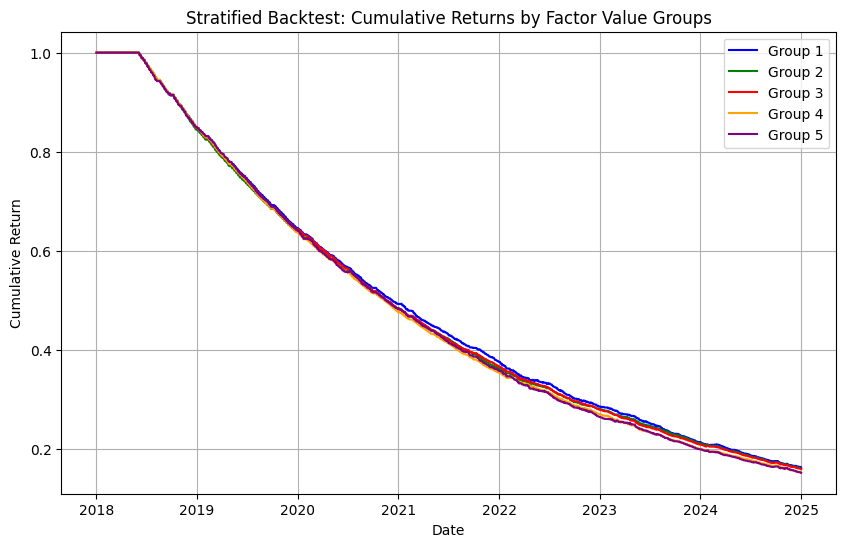

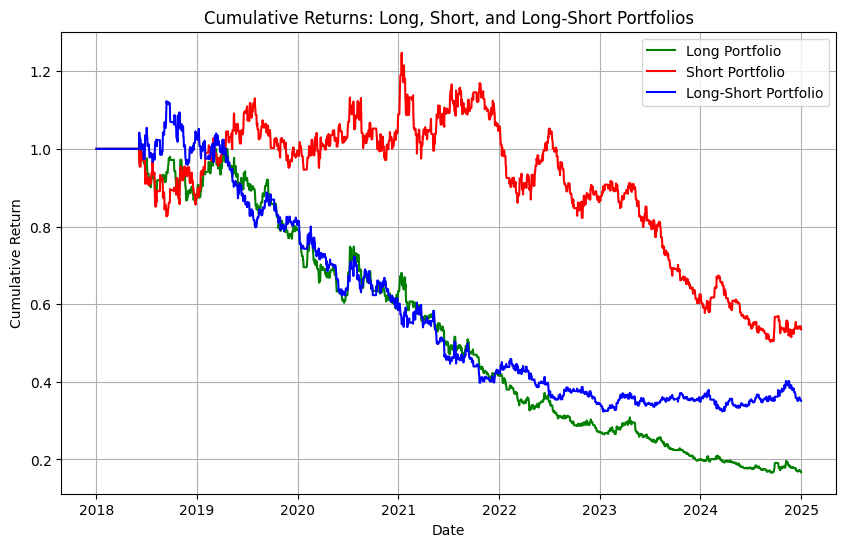

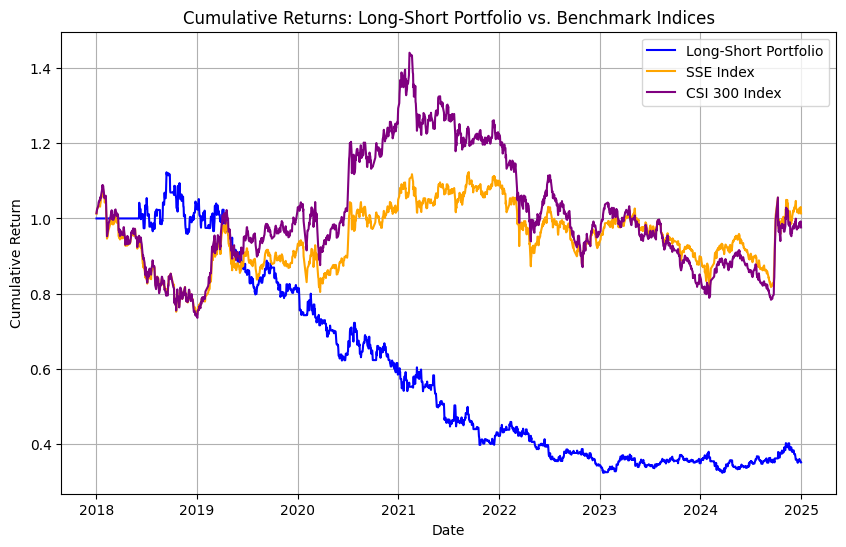

In [19]:
if __name__ == "__main__":
    main()